In [2]:
pg_sql_query = """
    WITH MaxDeliveryDates AS (
      SELECT
        so.id AS supplier_order_id,
        MAX(s.rc_delivered_ts) AS max_rc_delivered_ts,
        MAX(so.rc_accepted_ts) AS max_rc_accepted_ts
      FROM order_service.Supplier_Order so
      LEFT JOIN order_service.cargo_unit cu ON so.id = cu.supplier_order_id
      LEFT JOIN order_service.cargo_unit_shipment cus ON cu.id = cus.cargo_unit_id
      LEFT JOIN order_service.shipment s ON cus.shipment_id = s.id
      WHERE s.shipment_type = 'to_rc'
      GROUP BY so.id
    ),
    
    cat as (    
        select
           m.id,
           m.name,
           rc.top_name as top_category_name,
           rc.name as category_name
        from
           pim_catalog.model m
        left outer join (
                with recursive categories (id, parent_id, name, top_id, top_name) as (
                    select id, parent_id, name, id, name
                    from pim_catalog.category
                    where parent_id is null
                union all
                    select c.id, c.parent_id, c.name, top_id, top_name
                    from pim_catalog.category c
                    join categories r on r.id = c.parent_id
                )
                select * from categories
            ) rc on (m.category_id = rc.id)
    )
    
    
    SELECT
        so.id,
        so.supplier_id,
        so.catalog_id,
        oi.model_id,
        cat.name model_name,
        cat.category_name,
        cat.top_category_name,
        so.cost_net + coalesce(so.delivery_cost, 0) full_gmv,
        oi.quantity * (oi.unit_price + coalesce(oi.unit_delivery_price, 0)) model_gmv,
        c.name client_name,
        be.legal_entity,
        b2.name AS RC_name,
        so.create_ts,
        so.ready_ts,
        so.date_delivery rc_plan_delivery_date,
        CASE WHEN EXTRACT(ISODOW FROM so.date_delivery) IN (6, 7) THEN so.date_delivery + INTERVAL '4 days' ELSE so.date_delivery + INTERVAL '2 days' END AS adjusted_plan_delivery_date,
        so.rc_accepted_ts, 
        max_rc_delivered_ts,
        so.system_status,
        
        -- –ø—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –æ–ø–æ–∑–¥–∞–Ω–∏–µ –¥–ª—è rc_accepted
        (CASE WHEN EXTRACT(ISODOW FROM date_delivery) IN (6,7) THEN date_delivery + '4 days'::interval ELSE date_delivery + '2 days'::interval END) < CASE WHEN system_status IN ('SHIPPED', 'PACKED', 'READY') THEN NOW() ELSE rc_accepted_ts END AS is_late_to_rc_accepted,
        
        -- –ø—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞ –æ–ø–æ–∑–¥–∞–Ω–∏–µ –¥–ª—è rc_delivered
        (CASE WHEN EXTRACT(ISODOW FROM date_delivery) IN (6,7) THEN date_delivery + '4 days'::interval ELSE date_delivery + '2 days'::interval END) < CASE WHEN system_status IN ('SHIPPED', 'PACKED', 'READY') THEN NOW() ELSE COALESCE(max_rc_delivered_ts, rc_accepted_ts) END AS is_late_to_rc_delivered,
    
        -- –∑–∞ —Å–∫–æ–ª—å–∫–æ –ø–ª–∞–Ω–∏—Ä–æ–≤–∞–ª–æ—Å—å –¥–æ—Å—Ç–∞–≤–∏—Ç—å
        CEIL(EXTRACT(EPOCH FROM (CASE WHEN EXTRACT(ISODOW FROM date_delivery) IN (6,7) THEN date_delivery + INTERVAL '4 days' ELSE date_delivery + INTERVAL '2 days' END - so.create_ts)))/86400 AS planned_days,
    
        -- –∑–∞ —Å–∫–æ–ª—å–∫–æ –¥–æ—Å—Ç–∞–≤–∏–ª–∏
        CEIL(EXTRACT(EPOCH FROM (so.rc_accepted_ts - so.create_ts)) / 86400) AS actual_days,
        
        DENSE_RANK() OVER (
            ORDER BY so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts)
        ) AS cluster_id,
        
        FLOOR(EXTRACT(EPOCH FROM (
            MAX(so.ready_ts) OVER (PARTITION BY so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts)) 
            - MIN(so.ready_ts) OVER (PARTITION BY so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts))
        )) / 86400) AS form_days,
    
        so.available as stored
    
    FROM order_service.order_item oi 
    LEFT JOIN order_service.supplier_order so ON oi.supplier_order_id = so.id 
    LEFT JOIN order_service.Order o ON oi.order_id = o.id
    LEFT JOIN client_service.basis b ON b.id = o.basis_id
    LEFT JOIN client_service.business_entity be ON be.id = b.be_id
    LEFT JOIN dictionary_service.distribution_center b2 ON CASE 
        WHEN so.distribution_center_id IS NOT NULL THEN so.distribution_center_id = b2.id 
        ELSE o.distribution_basis_id = b2.id 
    END
    LEFT JOIN client_service.client c ON o.client_id = c.id 
    LEFT JOIN cat ON oi.model_id = cat.id
    LEFT JOIN MaxDeliveryDates mdd ON mdd.supplier_order_id = so.id
    WHERE system_status NOT IN ('CANCELED', 'DRAFT', 'DECLINED', 'WAITING', 'RETURNED', 'ACCEPTED')
    AND so.create_ts > '06.01.2024'
    AND so.rc_accepted_ts IS NOT NULL
    AND so.ready_ts IS NOT NULL
    and max_rc_delivered_ts != so.rc_accepted_ts
    and max_rc_delivered_ts is not null
    order by so.supplier_id, b2.name, DATE_TRUNC('day', so.rc_accepted_ts), so.ready_ts 
""""

SyntaxError: unterminated string literal (detected at line 101) (2538642267.py, line 101)

In [1]:
import pandas as pd
import warnings

# –û—Ç–∫–ª—é—á–∏—Ç—å –≤—Å–µ –ø—Ä–µ–¥—É–ø—Ä–µ–∂–¥–µ–Ω–∏—è
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('rc_delays_26.06.csv')

In [5]:
df.head(5)

id  supplier_id  catalog_id  model_id  \
0   54238            1           1   1856778   
1   49786            1         710       836   
2   50596            1         356    670838   
3  131121            1        1829    199737   
4  142728            1        1829   1494603   

                                          model_name           category_name  \
0  –ö–æ–º–ø–ª–µ–∫—Ç –ø—Ä–æ–≤–æ–¥–æ–≤ –ø—Ä–∏–∫—É—Ä–∏–≤–∞–Ω–∏—è 300 –ê, 2,5 –º, 1...        –ü—É—Å–∫–æ–≤—ã–µ –ø—Ä–æ–≤–æ–¥–∞   
1  –ö—É–≤–∞–ª–¥–∞ –∫–æ–≤–∞–Ω–∞—è –ü—Ä–æ—Ñ–∏ —Å —Ñ–∏–±–µ—Ä–≥–ª–∞—Å–æ–≤–æ–π –æ–±—Ä–µ–∑–∏–Ω–µ...                 –ö—É–≤–∞–ª–¥–∞   
2             –°—Ç—Ä–æ–ø –°–¢–ü-–°–¢–ü-15/10000 –†–î 24-–°–ó–ö-01-01      –°—Ç—Ä–æ–ø—ã —Ç–µ–∫—Å—Ç–∏–ª—å–Ω—ã–µ   
3              –ú–æ–ª–æ—Ç–æ–∫ –æ—Ç–±–æ–π–Ω—ã–π –ø–Ω–µ–≤–º–∞—Ç–∏—á–µ—Å–∫–∏–π –ú–û–ü-3  –ü–Ω–µ–≤–º–∞—Ç–∏—á–µ—Å–∫–∏–π –º–æ–ª–æ—Ç–æ–∫   
4              –ú–∞—à–∏–Ω–∞ –ø–æ–ª–æ–º–æ–µ—á–Ω–∞—è TOR MINI 350 —Å –ê–ö–ë      –ü–æ–ª–æ–º–æ–µ—á–Ω—ã–µ –º–∞—à–∏–Ω—ã   

               top_category_name  full_gmv  model_gmv  client_name  ...  \
0          –ê–≤—Ç–æ—Ç–æ–≤–∞—Ä—ã –∏ –∑–∞–ø—á–∞—Å—Ç–∏       833      833.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...   
1         –°—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –∏ —Ä–µ–º–æ–Ω—Ç      2871     2871.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...   
2         –°—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –∏ —Ä–µ–º–æ–Ω—Ç     26773    26773.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...   
3         –°—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –∏ —Ä–µ–º–æ–Ω—Ç    422431   422431.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...   
4  –ü—Ä–æ—Ñ–µ—Å—Å–∏–æ–Ω–∞–ª—å–Ω–æ–µ –æ–±–æ—Ä—É–¥–æ–≤–∞–Ω–∏–µ    309086   309086.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...   

        rc_accepted_ts  max_rc_delivered_ts system_status  \
0  2024-08-23 12:16:02  2024-08-21 13:01:16     DELIVERED   
1  2024-09-03 15:33:51  2024-08-21 13:01:43     DELIVERED   
2  2024-09-25 11:39:36  2024-08-21 13:01:36     DELIVERED   
3  2025-04-30 11:46:16  2025-04-30 11:46:16     DELIVERED   
4  2025-04-30 11:43:49  2025-04-30 11:43:49     DELIVERED   

  is_late_to_rc_accepted is_late_to_rc_delivered planned_days actual_days  \
0                  False                   False           65          52   
1                   True                    True           71          85   
2                   True                   False           76         101   
3                   True                    True           50          79   
4                   True                    True           21          56   

  cluster_id form_days  stored  
0          1         0   False  
1          2         0   False  
2          3         0   False  
3          4        36    True  
4          4        36    True  

[5 rows x 26 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43066 entries, 0 to 43065
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           43066 non-null  int64  
 1   supplier_id                  43066 non-null  int64  
 2   catalog_id                   43066 non-null  int64  
 3   model_id                     43066 non-null  int64  
 4   model_name                   43066 non-null  object 
 5   category_name                43066 non-null  object 
 6   top_category_name            43066 non-null  object 
 7   full_gmv                     43066 non-null  int64  
 8   model_gmv                    43066 non-null  float64
 9   client_name                  43066 non-null  object 
 10  legal_entity                 43066 non-null  object 
 11  rc_name                      43066 non-null  object 
 12  create_ts                    43066 non-null  object 
 13  ready_ts        

In [9]:
df.describe()

id   supplier_id    catalog_id      model_id      full_gmv  \
count   43066.000000  43066.000000  43066.000000  4.306600e+04  4.306600e+04   
mean   125849.122463    783.508870    958.343148  8.803404e+05  6.745385e+04   
std     39899.044402    934.461082    859.291896  7.406730e+05  2.829404e+05   
min     47821.000000      1.000000      1.000000  2.600000e+01  7.000000e+00   
25%     92714.500000     18.000000    143.000000  2.208865e+05  5.043250e+03   
50%    131953.000000    304.000000    850.000000  5.278390e+05  1.435700e+04   
75%    162298.000000   1545.000000   1818.000000  1.501624e+06  4.265375e+04   
max    182034.000000   3744.000000   3368.000000  2.800771e+06  9.400235e+06   

          model_gmv  planned_days   actual_days    cluster_id     form_days  
count  4.306600e+04  43066.000000  43066.000000  43066.000000  43066.000000  
mean   2.621541e+04     40.011262     45.402800   2687.234570     39.544211  
std    1.478971e+05     27.546642     41.656958   2249.211815     46.000544  
min    2.200000e-01      2.000000      1.000000      1.000000      0.000000  
25%    1.305000e+03     22.000000     19.000000    692.000000      6.000000  
50%    3.899000e+03     32.000000     31.000000   2048.000000     21.000000  
75%    1.354575e+04     52.000000     58.000000   4978.000000     60.000000  
max    8.365430e+06    434.000000    366.000000   6777.000000    336.000000

In [11]:
df['ready_ts'] = pd.to_datetime(df['ready_ts'])
df['rc_accepted_ts'] = pd.to_datetime(df['rc_accepted_ts'])
df['adjusted_plan_delivery_date'] = pd.to_datetime(df['adjusted_plan_delivery_date'])

In [13]:
# –°–æ–∑–¥–∞–µ–º DataFrame —Å —É–Ω–∏–∫–∞–ª—å–Ω—ã–º–∏ cluster_id –∏ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–º –∏–º consolidated_cluster
cluster_consolidation = (
    df[['cluster_id', 'form_days']]
    .drop_duplicates()
    .assign(consolidated_cluster=lambda x: x['form_days'] > 3)
)

# –ü—Ä–∏—Å–æ–µ–¥–∏–Ω—è–µ–º –ø–æ cluster_id
df = df.merge(cluster_consolidation[['cluster_id', 'consolidated_cluster']], on='cluster_id', how='left')

In [15]:
# ABC-–∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –ø–æ model_gmv
supplier_gmv = (
    df.groupby('supplier_id', as_index=False)
    .agg(total_gmv=('model_gmv', 'sum'))
    .sort_values('total_gmv', ascending=False, ignore_index=True)
)

supplier_gmv['cumulative_percent'] = (supplier_gmv['total_gmv'].cumsum() / supplier_gmv['total_gmv'].sum()) * 100
supplier_gmv['abc_category'] = supplier_gmv['cumulative_percent'].apply(
    lambda x: 'A' if x <= 70 else 'B' if x <= 90 else 'C'
)

df = df.merge(supplier_gmv[['supplier_id', 'abc_category']], on='supplier_id', how='left')

In [17]:
df['abc_category'].value_counts()

abc_category
A    32225
B     7599
C     3242
Name: count, dtype: int64

In [19]:
df.groupby('abc_category')['supplier_id'].nunique()

abc_category
A     44
B     59
C    176
Name: supplier_id, dtype: int64

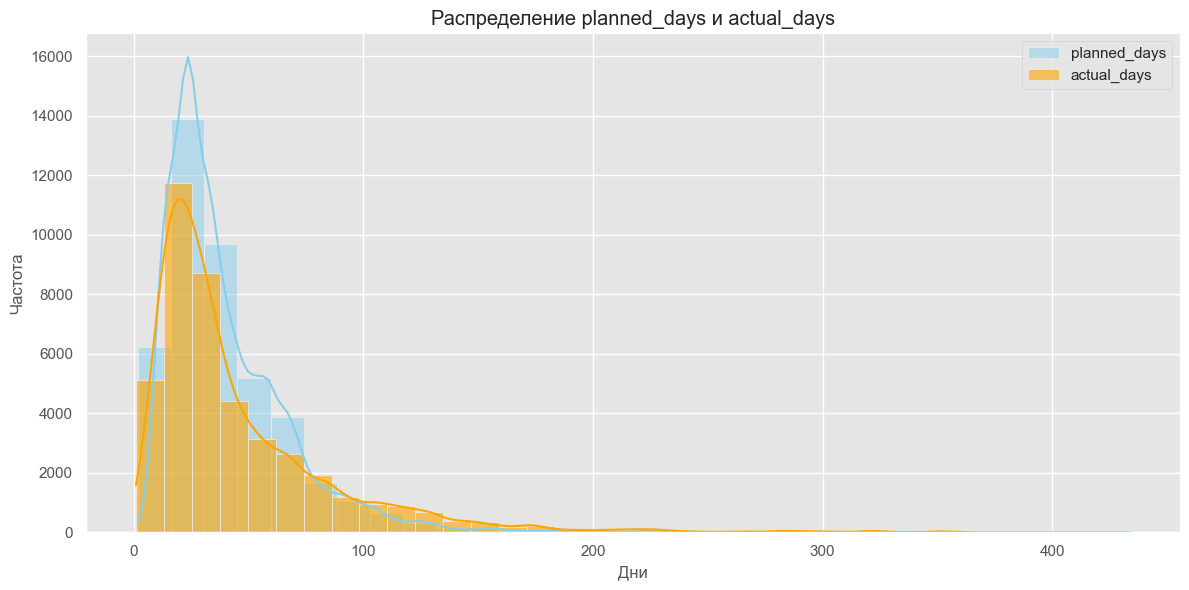

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# –ù–∞—Å—Ç—Ä–æ–π–∫–∏ –æ—Ç–æ–±—Ä–∞–∂–µ–Ω–∏—è –≥—Ä–∞—Ñ–∏–∫–æ–≤
sns.set(style='whitegrid')
plt.style.use('ggplot')

# 1. –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ planned_days –∏ actual_days
plt.figure(figsize=(12, 6))
sns.histplot(df['planned_days'], bins=30, kde=True, color='skyblue', label='planned_days')
sns.histplot(df['actual_days'], bins=30, kde=True, color='orange', alpha=0.6, label='actual_days')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ planned_days –∏ actual_days')
plt.xlabel('–î–Ω–∏')
plt.ylabel('–ß–∞—Å—Ç–æ—Ç–∞')
plt.legend()
plt.tight_layout()
plt.show()

## –ü–ª–∞–Ω–æ–≤–æ–µ (planned_days) –≤—Ä–µ–º—è –∏–º–µ–µ—Ç –∑–∞–º–µ—Ç–Ω—ã–π –ø–∏–∫ –≤ —Å—Ä–∞–≤–Ω–µ–Ω–∏–∏ —Å —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏–º (actual_days) –≤—Ä–µ–º–µ–Ω–µ–º

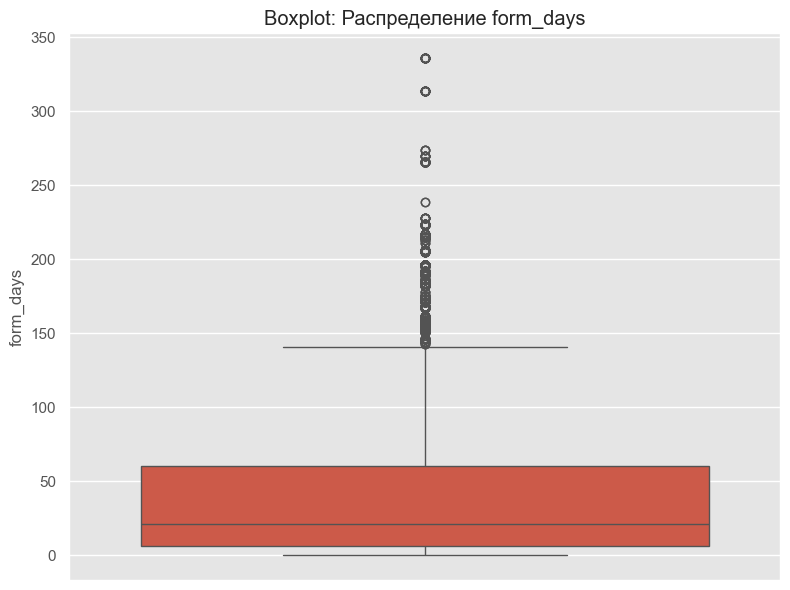

In [23]:
# 2. Boxplot –ø–æ form_days
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['form_days'])
plt.title('Boxplot: –†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ form_days')
plt.ylabel('form_days')
plt.tight_layout()
plt.show()

## –í —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–∏ –≤—Ä–µ–º–µ–Ω–∏ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è (form_days) - –∑–∞–º–µ—Ç–Ω—ã —è–≤–Ω—ã–µ –≤—ã–±—Ä–æ—Å—ã

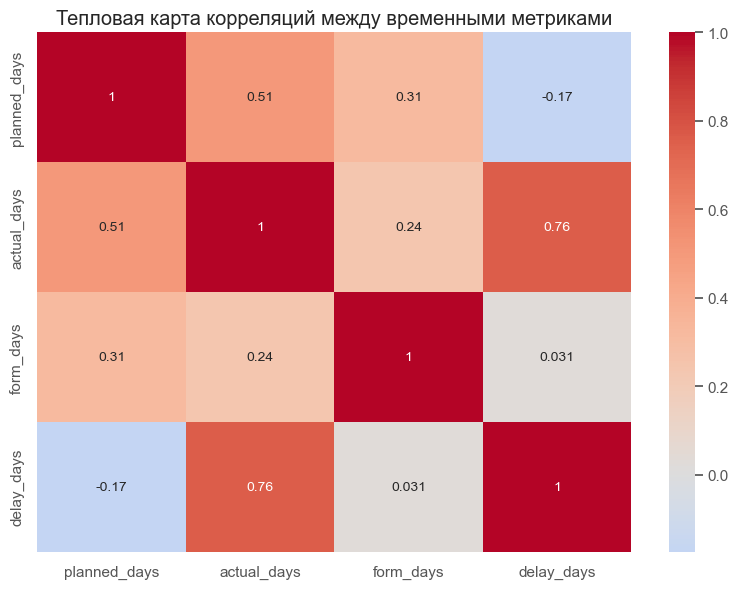

In [27]:
# 3. –¢–µ–ø–ª–æ–≤–∞—è –∫–∞—Ä—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π
df['delay_days'] = df['actual_days'] - df['planned_days']
corr = df[['planned_days', 'actual_days', 'form_days', 'delay_days']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('–¢–µ–ø–ª–æ–≤–∞—è –∫–∞—Ä—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–π –º–µ–∂–¥—É –≤—Ä–µ–º–µ–Ω–Ω—ã–º–∏ –º–µ—Ç—Ä–∏–∫–∞–º–∏')
plt.tight_layout()
plt.show()

## –û–ø–æ–∑–¥–∞–Ω–∏—è (delay_days) –ø–æ—á—Ç–∏ –Ω–µ –∫–æ—Ä—Ä–µ–ª–∏—Ä—É—é—Ç —Å –≤—Ä–µ–º–µ–Ω–µ–º –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ (form_days)

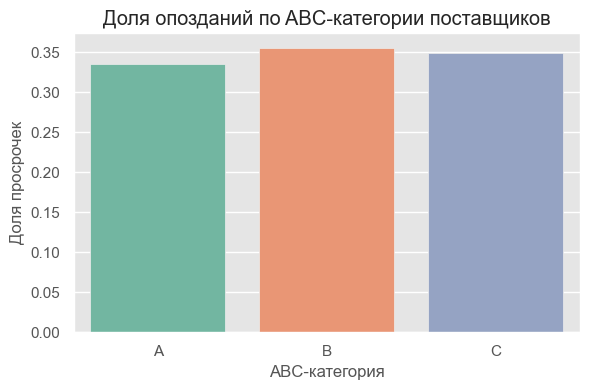

In [30]:
# 4. –î–æ–ª—è –ø—Ä–æ—Å—Ä–æ—á–µ–∫ (is_late_to_rc_delivered) –ø–æ abc_category
late_by_abc = df.groupby('abc_category')['is_late_to_rc_delivered'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(x='abc_category', y='is_late_to_rc_delivered', data=late_by_abc, palette='Set2')
plt.title('–î–æ–ª—è –æ–ø–æ–∑–¥–∞–Ω–∏–π –ø–æ ABC-–∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤')
plt.xlabel('ABC-–∫–∞—Ç–µ–≥–æ—Ä–∏—è')
plt.ylabel('–î–æ–ª—è –ø—Ä–æ—Å—Ä–æ—á–µ–∫')
plt.tight_layout()
plt.show()

## –û–ø–æ–∑–¥–∞–Ω–∏—è –Ω–µ —Ç–∞–∫ —É–∂ –∑–∞–≤–∏—Å—è—Ç –æ—Ç —É—Ä–æ–≤–Ω—è –ø–æ—Å—Ç–∞–≤—â–∏–∫–∞.

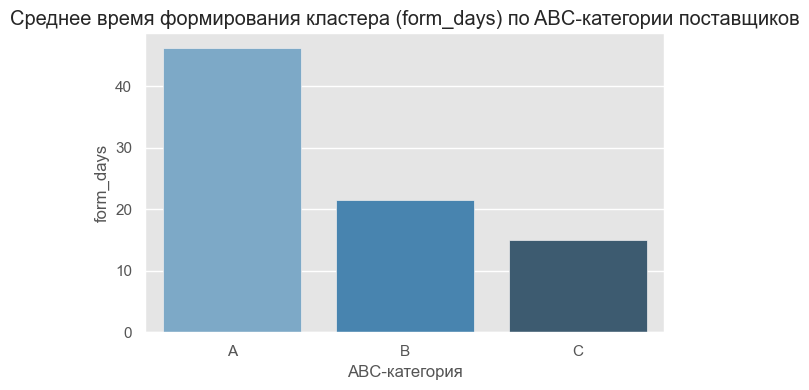

In [33]:
# 5. –°—Ä–µ–¥–Ω–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ form_days –ø–æ abc_category
avg_form_by_abc = df.groupby('abc_category')['form_days'].mean().reset_index()
plt.figure(figsize=(6, 4))
sns.barplot(x='abc_category', y='form_days', data=avg_form_by_abc, palette='Blues_d')
plt.title('–°—Ä–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –∫–ª–∞—Å—Ç–µ—Ä–∞ (form_days) –ø–æ ABC-–∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤')
plt.xlabel('ABC-–∫–∞—Ç–µ–≥–æ—Ä–∏—è')
plt.ylabel('form_days')
plt.tight_layout()
plt.show()

## –ó–∞–º–µ—Ç–Ω–æ, —á—Ç–æ —á–∞—â–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä—É—é—Ç –ø–æ–¥–∑–∞–∫–∞–∑—ã –∏–º–µ–Ω–Ω–æ –∫—Ä—É–ø–Ω—ã–µ –ø–æ—Å—Ç–∞–≤—â–∏–∫–∏.

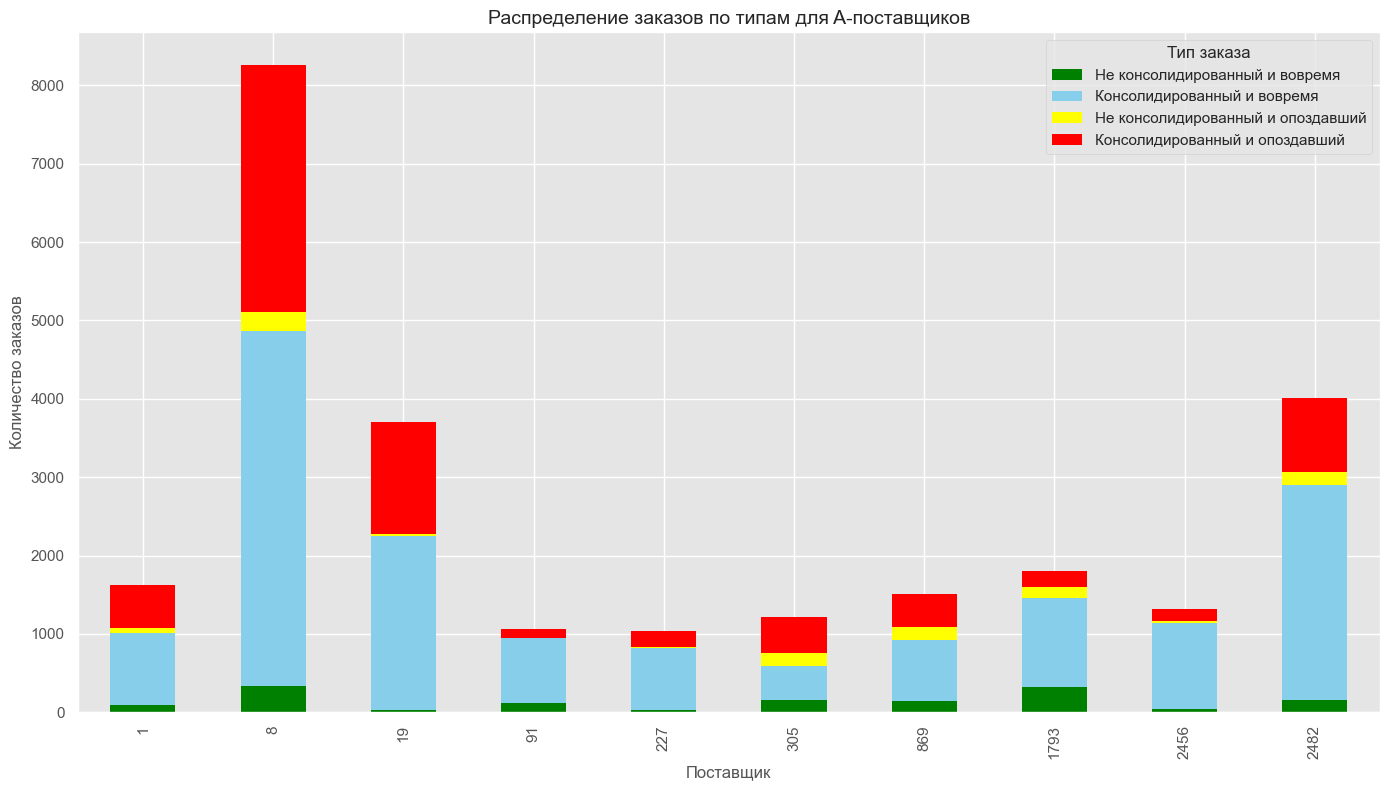

In [36]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# 1. –§–∏–ª—å—Ç—Ä—É–µ–º —Ç–æ–ª—å–∫–æ A-–ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤
df_top_orders = df[df.groupby('supplier_id').transform('size') > 1000]

# 2. –ö–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –∑–∞–∫–∞–∑—ã
def classify_order(row):
    if row['consolidated_cluster'] and row['is_late_to_rc_delivered']:
        return '–ö–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –æ–ø–æ–∑–¥–∞–≤—à–∏–π'
    elif not row['consolidated_cluster'] and row['is_late_to_rc_delivered']:
        return '–ù–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –æ–ø–æ–∑–¥–∞–≤—à–∏–π'
    elif row['consolidated_cluster'] and not row['is_late_to_rc_delivered']:
        return '–ö–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –≤–æ–≤—Ä–µ–º—è'
    else:
        return '–ù–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –≤–æ–≤—Ä–µ–º—è'

df_top_orders = df_top_orders.copy()
df_top_orders['order_category'] = df_top_orders.apply(classify_order, axis=1)

# 3. –ì—Ä—É–ø–ø–∏—Ä—É–µ–º
category_counts = df_top_orders.groupby(['supplier_id', 'order_category']).size().unstack(fill_value=0)

# 4. –ü–æ—Ä—è–¥–æ–∫ —Å—Ç–æ–ª–±—Ü–æ–≤ –∏ —Ü–≤–µ—Ç–∞
order = [
    '–ù–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –≤–æ–≤—Ä–µ–º—è',
    '–ö–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –≤–æ–≤—Ä–µ–º—è',
    '–ù–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –æ–ø–æ–∑–¥–∞–≤—à–∏–π',
    '–ö–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –æ–ø–æ–∑–¥–∞–≤—à–∏–π'
]

colors = {
    '–ö–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –æ–ø–æ–∑–¥–∞–≤—à–∏–π': 'red',
    '–ù–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –æ–ø–æ–∑–¥–∞–≤—à–∏–π': 'yellow',
    '–ö–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –≤–æ–≤—Ä–µ–º—è': 'skyblue',
    '–ù–µ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∏ –≤–æ–≤—Ä–µ–º—è': 'green'
}

# 5. –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫
plt.figure(figsize=(14, 8))
category_counts[order].plot(kind='bar', stacked=True, color=colors, edgecolor='none', ax=plt.gca())

plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∑–∞–∫–∞–∑–æ–≤ –ø–æ —Ç–∏–ø–∞–º –¥–ª—è A-–ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤", fontsize=14)
plt.xlabel("–ü–æ—Å—Ç–∞–≤—â–∏–∫", fontsize=12)
plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–∫–∞–∑–æ–≤", fontsize=12)
plt.xticks(rotation=90)
plt.legend(title="–¢–∏–ø –∑–∞–∫–∞–∑–∞")
plt.tight_layout()
plt.show()

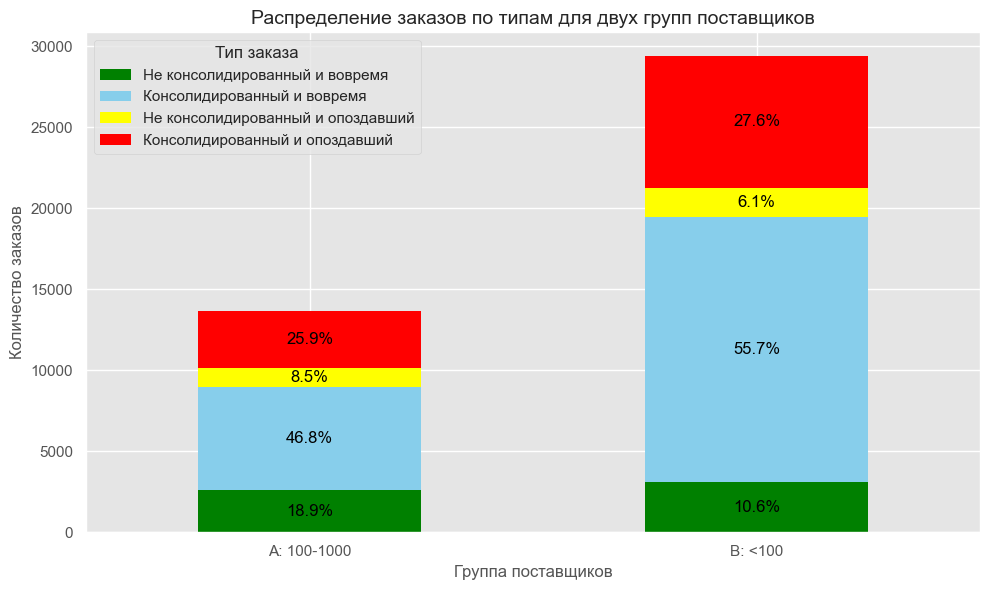

In [38]:
# –®–∞–≥ 1: –ü—Ä–æ—Å—Ç–∞–≤–ª—è–µ–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–∫–∞–∑–æ–≤ –Ω–∞ –ø–æ—Å—Ç–∞–≤—â–∏–∫–∞
group_counts = df.groupby('supplier_id', as_index=False).size()

# –®–∞–≥ 2: –ü—Ä–æ—Å—Ç–∞–≤–ª—è–µ–º –≥—Ä—É–ø–ø—É –∫–∞–∂–¥–æ–º—É –ø–æ—Å—Ç–∞–≤—â–∏–∫—É
def assign_group(row):
    if 100 <= row['size'] <= 1000:
        return 'A: 100-1000'
    else:
        return 'B: <100'

group_counts['group'] = group_counts.apply(assign_group, axis=1)

# –®–∞–≥ 3: –î–æ–±–∞–≤–ª—è–µ–º –≥—Ä—É–ø–ø—É –≤ –æ—Å–Ω–æ–≤–Ω–æ–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
df_grouped = df.merge(group_counts[['supplier_id', 'group']], on='supplier_id', how='left')

# –®–∞–≥ 4: –ö–ª–∞—Å—Å–∏—Ñ–∏—Ü–∏—Ä—É–µ–º –∑–∞–∫–∞–∑—ã
df_grouped = df_grouped.copy()
df_grouped['order_category'] = df_grouped.apply(classify_order, axis=1)

# –®–∞–≥ 5: –ê–≥—Ä–µ–≥–∏—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –ø–æ –≥—Ä—É–ø–ø–∞–º
category_by_group = (
    df_grouped[df_grouped['group'].isin(['A: 100-1000', 'B: <100'])]
    .groupby(['group', 'order_category'])
    .size()
    .unstack(fill_value=0)
)

# –£–±–µ–¥–∏–º—Å—è, —á—Ç–æ –≤—Å–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏ –ø—Ä–∏—Å—É—Ç—Å—Ç–≤—É—é—Ç –≤ –Ω—É–∂–Ω–æ–º –ø–æ—Ä—è–¥–∫–µ
category_by_group = category_by_group.reindex(columns=order)

# –®–∞–≥ 6: –°—Ç—Ä–æ–∏–º –≥—Ä–∞—Ñ–∏–∫ —Å –ø–æ–¥–ø–∏—Å—è–º–∏ %
plt.figure(figsize=(10, 6))
ax = category_by_group.plot(kind='bar', stacked=True, color=colors, edgecolor='none', ax=plt.gca())

plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∑–∞–∫–∞–∑–æ–≤ –ø–æ —Ç–∏–ø–∞–º –¥–ª—è –¥–≤—É—Ö –≥—Ä—É–ø–ø –ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤", fontsize=14)
plt.xlabel("–ì—Ä—É–ø–ø–∞ –ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤", fontsize=12)
plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –∑–∞–∫–∞–∑–æ–≤", fontsize=12)
plt.xticks(rotation=0)
plt.legend(title="–¢–∏–ø –∑–∞–∫–∞–∑–∞")
plt.tight_layout()

# –î–æ–±–∞–≤–ª—è–µ–º –ø–æ–¥–ø–∏—Å–∏ –ø—Ä–æ—Ü–µ–Ω—Ç–æ–≤
for container in ax.containers:
    # –ò–≥–Ω–æ—Ä–∏—Ä—É–µ–º "–Ω–µ–≤–∏–¥–∏–º—ã–µ" –∫–æ–Ω—Ç–µ–π–Ω–µ—Ä—ã
    if isinstance(container, matplotlib.container.BarContainer):
        for bar in container.patches:
            # –ü–æ–ª—É—á–∞–µ–º –ø–æ–∑–∏—Ü–∏—é –∏ –≤—ã—Å–æ—Ç—É –±–∞—Ä–∞
            x = bar.get_x() + bar.get_width() / 2
            y = bar.get_y() + bar.get_height() / 2

            # –í—ã—á–∏—Å–ª—è–µ–º –ø—Ä–æ—Ü–µ–Ω—Ç –æ—Ç –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –≤ —ç—Ç–æ–º —Å—Ç–æ–ª–±—Ü–µ
            total = category_by_group.iloc[int(bar.get_x() / bar.get_width())].sum()
            percent = bar.get_height() / total * 100 if total != 0 else 0

            # –ü–∏—à–µ–º —Ç–µ–∫—Å—Ç
            if percent > 5:  # –ß—Ç–æ–±—ã –Ω–µ –ø–µ—Ä–µ–≥—Ä—É–∂–∞—Ç—å –≥—Ä–∞—Ñ–∏–∫, –ø–æ–∫–∞–∑—ã–≤–∞–µ–º —Ç–æ–ª—å–∫–æ –∑–Ω–∞—á–∏–º—ã–µ –¥–æ–ª–∏
                ax.annotate(f'{percent:.1f}%', xy=(x, y), xytext=(0, 0),
                            textcoords='offset points', ha='center', va='center',
                            fontsize=12, color='black', weight='normal')

plt.show()

# **–¶–µ–ª—å –ø–µ—Ä–≤–æ–≥–æ —ç—Ç–∞–ø–∞ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è**
–û–ø—Ä–µ–¥–µ–ª–∏—Ç—å, —Å—É—â–µ—Å—Ç–≤—É–µ—Ç –ª–∏ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–∞—è —Å–≤—è–∑—å –º–µ–∂–¥—É **–∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–µ–π –∑–∞–∫–∞–∑–æ–≤** (–∏–∑–º–µ—Ä—è–µ–º–æ–π —á–µ—Ä–µ–∑ `form_days`) –∏ —É–≤–µ–ª–∏—á–µ–Ω–∏–µ–º –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ (`delay_days`).

---
### **–§–æ—Ä–º—É–ª–∏—Ä–æ–≤–∫–∞ –≥–∏–ø–æ—Ç–µ–∑**
### **–ù—É–ª–µ–≤–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞ (H‚ÇÄ):**
–ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä—ã **–Ω–µ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ (`delay_days`)**.  
- **–ü—Ä–µ–¥–ø–æ–ª–æ–∂–µ–Ω–∏–µ:** –ó–∞–∫–∞–∑—ã, –¥–ª—è –∫–æ—Ç–æ—Ä—ã—Ö `form_days > 3`, **–Ω–µ –∏–º–µ—é—Ç –∑–Ω–∞—á–∏–º–æ –±–æ–ª—å—à–∏—Ö –∑–∞–¥–µ—Ä–∂–µ–∫** –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –∑–∞–∫–∞–∑–∞–º–∏, –¥–ª—è –∫–æ—Ç–æ—Ä—ã—Ö `form_days ‚â§ 3`.

### **–ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞ (H‚ÇÅ):**
–ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä—ã —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç —Ä–∞–∑–Ω–∏—Ü—É –º–µ–∂–¥—É —Ñ–∞–∫—Ç–∏—á–µ—Å–∫–∏–º –∏ –∑–∞–ø–ª–∞–Ω–∏—Ä–æ–≤–∞–Ω–Ω—ã–º –≤—Ä–µ–º–µ–Ω–µ–º –¥–æ—Å—Ç–∞–≤–∫–∏ (`delay_days = actual_days - planned_days`), —Ç–æ –µ—Å—Ç—å —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç —Ä–∏—Å–∫ –∏ –≤–µ–ª–∏—á–∏–Ω—É –æ–ø–æ–∑–¥–∞–Ω–∏—è.  
- **–ü—Ä–µ–¥–ø–æ–ª–æ–∂–µ–Ω–∏–µ:** –ß–µ–º –¥–æ–ª—å—à–µ –¥–ª–∏—Ç—Å—è —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –≥—Ä—É–∑–æ–º–µ—Å—Ç–∞ (`form_days`), —Ç–µ–º –±–æ–ª—å—à–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å —Ç–æ–≥–æ, —á—Ç–æ —Å—Ç–∞—Ä—ã–µ –∑–∞–∫–∞–∑—ã –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ –±—É–¥—É—Ç –∏–º–µ—Ç—å –∑–Ω–∞—á–∏–º–æ –±–æ–ª—å—à–∏–µ –∑–∞–¥–µ—Ä–∂–∫–∏ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –Ω–æ–≤—ã–º–∏ –∑–∞–∫–∞–∑–∞–º–∏.

## –ü—Ä–æ–≤–µ—Ä–∫–∞ –≥–∏–ø–æ—Ç–µ–∑—ã:

In [40]:
# –í—ã—á–∏—Å–ª—è–µ–º delay_days
df['delay_days'] = df['actual_days'] - df['planned_days']

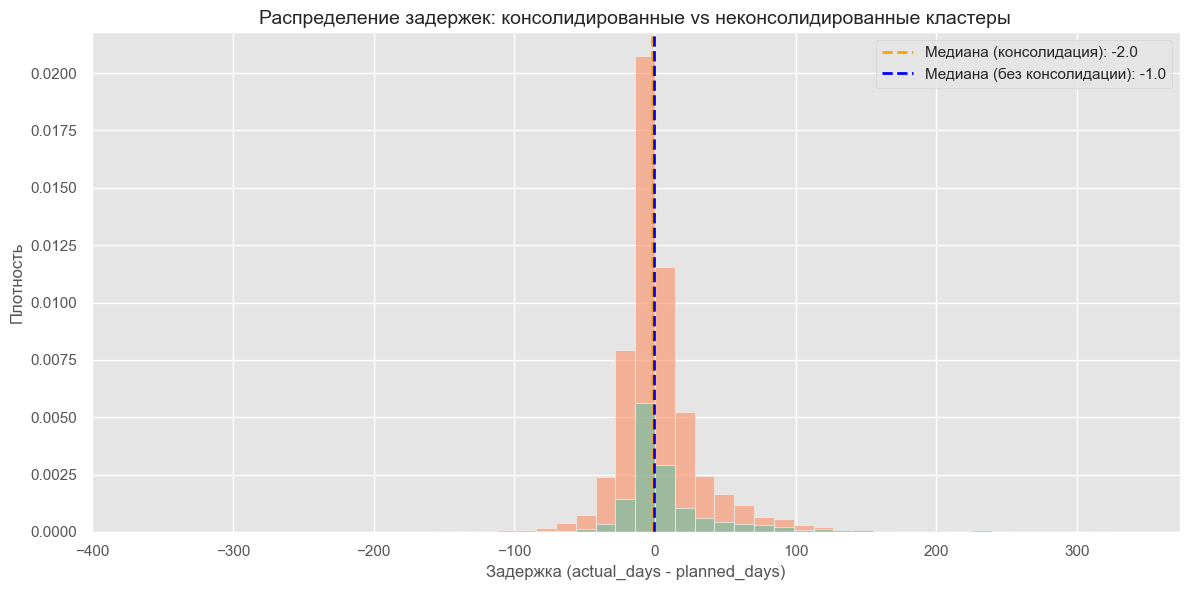

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='delay_days',
    hue='consolidated_cluster',
    bins=50,
    alpha=0.6,
    palette='Set2',
    stat='density'
)

# –î–æ–±–∞–≤–ª—è–µ–º –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω—ã–µ –ª–∏–Ω–∏–∏ —Å—Ä–µ–¥–Ω–∏—Ö
median_consolidated = df[df['consolidated_cluster']]['delay_days'].median()
median_not_consolidated = df[~df['consolidated_cluster']]['delay_days'].median()

plt.axvline(median_consolidated, color='orange', linestyle='--', linewidth=2, label=f'–ú–µ–¥–∏–∞–Ω–∞ (–∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è): {median_consolidated:.1f}')
plt.axvline(median_not_consolidated, color='blue', linestyle='--', linewidth=2, label=f'–ú–µ–¥–∏–∞–Ω–∞ (–±–µ–∑ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏): {median_not_consolidated:.1f}')

plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∑–∞–¥–µ—Ä–∂–µ–∫: –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ vs –Ω–µ–∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –∫–ª–∞—Å—Ç–µ—Ä—ã', fontsize=14)
plt.xlabel('–ó–∞–¥–µ—Ä–∂–∫–∞ (actual_days - planned_days)', fontsize=12)
plt.ylabel('–ü–ª–æ—Ç–Ω–æ—Å—Ç—å', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### –ú–µ–¥–∏–∞–Ω—ã –∏–¥–µ–Ω—Ç–∏—á–Ω—ã–µ.
    –ü—Ä–æ–≤–æ–∂—É U-test, –∏–±–æ —Å—á–∏—Ç–∞—é, —á—Ç–æ –≤—ã–±–æ—Ä–∫–∏ –∏–º–µ—é—Ç "—Ö–≤–æ—Å—Ç—ã"

In [65]:
from scipy.stats import mannwhitneyu

# –®–∞–≥ 1: –§–æ—Ä–º–∏—Ä—É–µ–º –≥—Ä—É–ø–ø—ã –Ω–∞ –æ—Å–Ω–æ–≤–µ consolidated_cluster
group_non_consolidated = df[~df['consolidated_cluster']]['delay_days']
group_consolidated = df[df['consolidated_cluster']]['delay_days']

# –®–∞–≥ 2: –¢–µ—Å—Ç –ú–∞–Ω–Ω–∞-–£–∏—Ç–Ω–∏
result = mannwhitneyu(group_non_consolidated, group_consolidated, alternative='less')

# –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
if result.pvalue < 0.05:
    significance = "—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ"
else:
    significance = "—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –Ω–µ–∑–Ω–∞—á–∏–º–æ"

print(f"U-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: {result.statistic}, p-–∑–Ω–∞—á–µ–Ω–∏–µ: {result.pvalue:.3f} ({significance})")

U-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: 163472486.5, p-–∑–Ω–∞—á–µ–Ω–∏–µ: 1.000 (—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –Ω–µ–∑–Ω–∞—á–∏–º–æ)


### –†–µ–∑—É–ª—å—Ç–∞—Ç —Ç–µ—Å—Ç–µ –Ω–µ —è–≤–ª—è–µ—Ç—Å—è —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º—ã–º
–û—Ç–≤–µ—Ä–≥–Ω—É—Ç—å –Ω—É–ª–µ–≤—É—é –≥–∏–ø–æ—Ç–µ–∑—É –Ω–µ–≤–æ–∑–º–æ–∂–Ω–æ. –ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä—ã **–Ω–µ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ (`delay_days`)**. 

# –ò—Ç–æ–≥:
    –ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞, —á—Ç–æ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –ø—Ä–∏–≤–æ–¥–∏—Ç –∫ –±–û–ª—å—à–∏–º –∑–∞–¥–µ—Ä–∂–∫–∞–º - –Ω–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç—Å—è.
    –ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤, –∫–∞–∫ —Ç–∞–∫–æ–≤–∞—è, –Ω–µ –ø—Ä–∏–≤–æ–¥–∏—Ç –∫ —É–≤–µ–ª–∏—á–µ–Ω–∏—é —Å—Ä–æ–∫–æ–≤ –ø–æ—Å—Ç–∞–≤–∫–∏.

# **–¶–µ–ª—å –≤—Ç–æ—Ä–æ–≥–æ —ç—Ç–∞–ø–∞ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è**
–û–ø—Ä–µ–¥–µ–ª–∏—Ç—å, –≤–ª–∏—è–µ—Ç –ª–∏ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ –Ω–∞ –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ **"—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ**, –∏ –≤—ã—è–≤–∏—Ç—å –ø–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ `form_days`, –ø–æ—Å–ª–µ –∫–æ—Ç–æ—Ä–æ–≥–æ –∑–∞–¥–µ—Ä–∂–∫–∏ —Å—Ç–∞–Ω–æ–≤—è—Ç—Å—è –∫—Ä–∏—Ç–∏—á–µ—Å–∫–∏–º–∏.

---

### **–§–æ—Ä–º—É–ª–∏—Ä–æ–≤–∫–∞ –≥–∏–ø–æ—Ç–µ–∑**

#### **–û—Å–Ω–æ–≤–Ω–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞ (H‚ÇÄ):**
- –ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ **–Ω–µ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤** –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ.
- –¢–æ –µ—Å—Ç—å: –ó–∞–¥–µ—Ä–∂–∫–∏ –¥–ª—è "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤ (`delay_days`) –Ω–µ –∑–∞–≤–∏—Å—è—Ç –æ—Ç –¥–ª–∏—Ç–µ–ª—å–Ω–æ—Å—Ç–∏ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –≥—Ä—É–∑–æ–º–µ—Å—Ç–∞ (`form_days`).

#### **–ê–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω–∞—è –≥–∏–ø–æ—Ç–µ–∑–∞ (H‚ÇÅ):**
- –ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ **—É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤** –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ.
- –¢–æ –µ—Å—Ç—å: –ß–µ–º –¥–æ–ª—å—à–µ –¥–ª–∏—Ç—Å—è —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –≥—Ä—É–∑–æ–º–µ—Å—Ç–∞ (`form_days`), —Ç–µ–º –±–æ–ª—å—à–µ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –∑–Ω–∞—á–∏–º–æ –±–æ–ª—å—à–∏—Ö –∑–∞–¥–µ—Ä–∂–µ–∫ –¥–ª—è "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤.

In [67]:
filtered_df = df[df['form_days'] > 3]

# –ù–∞—Ö–æ–¥–∏–º "—Å—Ç–∞—Ä—ã–µ" –∑–∞–∫–∞–∑—ã (–º–∏–Ω–∏–º–∞–ª—å–Ω–∞—è ready_ts)
old_orders = (filtered_df.loc[filtered_df.groupby('cluster_id')['ready_ts'].idxmin()])

# –ù–∞—Ö–æ–¥–∏–º "–Ω–æ–≤—ã–µ" –∑–∞–∫–∞–∑—ã (–º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è ready_ts)
new_orders = (filtered_df.loc[filtered_df.groupby('cluster_id')['ready_ts'].idxmax()])

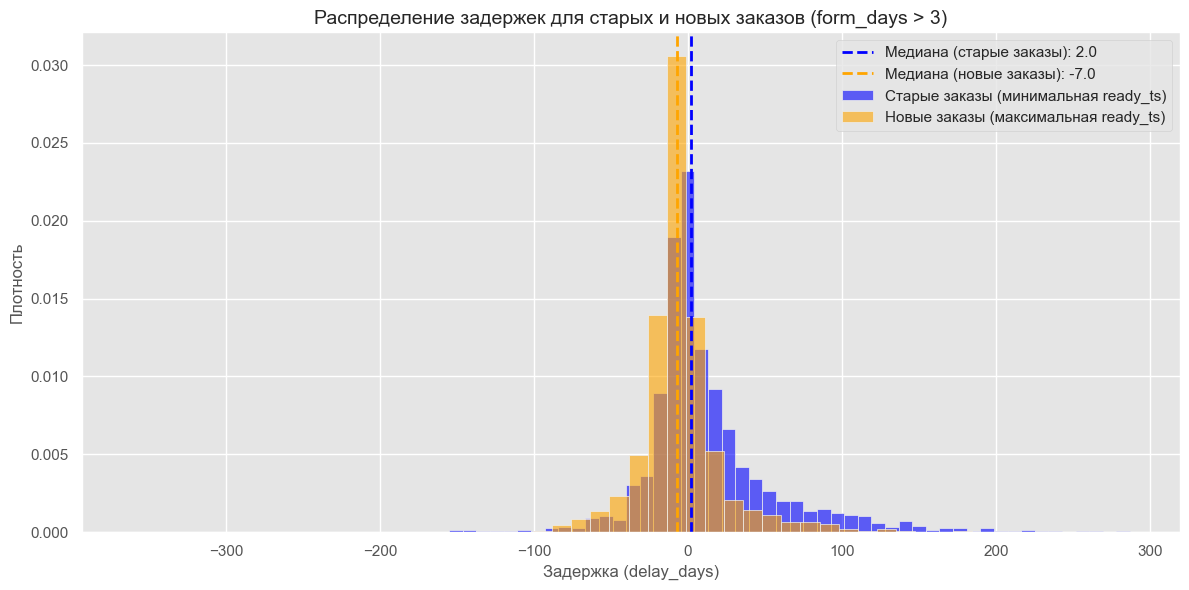

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –¥–ª—è "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤
sns.histplot(
    old_orders['delay_days'],
    bins=50,
    color='blue',
    alpha=0.6,
    label='–°—Ç–∞—Ä—ã–µ –∑–∞–∫–∞–∑—ã (–º–∏–Ω–∏–º–∞–ª—å–Ω–∞—è ready_ts)',
    stat='density'
)

# –ì–∏—Å—Ç–æ–≥—Ä–∞–º–º–∞ –¥–ª—è "–Ω–æ–≤—ã—Ö" –∑–∞–∫–∞–∑–æ–≤
sns.histplot(
    new_orders['delay_days'],
    bins=50,
    color='orange',
    alpha=0.6,
    label='–ù–æ–≤—ã–µ –∑–∞–∫–∞–∑—ã (–º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è ready_ts)',
    stat='density'
)

# –í—ã—á–∏—Å–ª—è–µ–º –º–µ–¥–∏–∞–Ω—ã
median_old = old_orders['delay_days'].median()
median_new = new_orders['delay_days'].median()

# –î–æ–±–∞–≤–ª—è–µ–º –≤–µ—Ä—Ç–∏–∫–∞–ª—å–Ω—ã–µ –ª–∏–Ω–∏–∏ –¥–ª—è –º–µ–¥–∏–∞–Ω
plt.axvline(median_old, color='blue', linestyle='--', linewidth=2, label=f'–ú–µ–¥–∏–∞–Ω–∞ (—Å—Ç–∞—Ä—ã–µ –∑–∞–∫–∞–∑—ã): {median_old:.1f}')
plt.axvline(median_new, color='orange', linestyle='--', linewidth=2, label=f'–ú–µ–¥–∏–∞–Ω–∞ (–Ω–æ–≤—ã–µ –∑–∞–∫–∞–∑—ã): {median_new:.1f}')

# –î–æ–±–∞–≤–ª—è–µ–º –∑–∞–≥–æ–ª–æ–≤–æ–∫ –∏ –º–µ—Ç–∫–∏ –æ—Å–µ–π
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∑–∞–¥–µ—Ä–∂–µ–∫ –¥–ª—è —Å—Ç–∞—Ä—ã—Ö –∏ –Ω–æ–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ (form_days > 3)', fontsize=14)
plt.xlabel('–ó–∞–¥–µ—Ä–∂–∫–∞ (delay_days)', fontsize=12)
plt.ylabel('–ü–ª–æ—Ç–Ω–æ—Å—Ç—å', fontsize=12)

# –î–æ–±–∞–≤–ª—è–µ–º –ª–µ–≥–µ–Ω–¥—É –∏ —Å–µ—Ç–∫—É
plt.legend()
plt.grid(True)
plt.tight_layout()

# –ü–æ–∫–∞–∑—ã–≤–∞–µ–º –≥—Ä–∞—Ñ–∏–∫
plt.show()

In [71]:
# –®–∞–≥ 1: –§–æ—Ä–º–∏—Ä—É–µ–º –≥—Ä—É–ø–ø—ã
group_old = old_orders['delay_days']
group_new = new_orders['delay_days']

# –®–∞–≥ 2: –¢–µ—Å—Ç –ú–∞–Ω–Ω–∞-–£–∏—Ç–Ω–∏ (–æ–¥–Ω–æ—Å—Ç–æ—Ä–æ–Ω–Ω–∏–π)
result = mannwhitneyu(group_old, group_new, alternative='greater')

# –ò–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
if result.pvalue < 0.05:
    significance = "—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ"
else:
    significance = "—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –Ω–µ–∑–Ω–∞—á–∏–º–æ"

print(f"U-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: {result.statistic}, p-–∑–Ω–∞—á–µ–Ω–∏–µ: {result.pvalue:.3f} ({significance})")

U-—Å—Ç–∞—Ç–∏—Å—Ç–∏–∫–∞: 3998966.0, p-–∑–Ω–∞—á–µ–Ω–∏–µ: 0.000 (—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ)


# **–í—ã–≤–æ–¥:**  
- –ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ **—É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤** –≤ –∫–ª–∞—Å—Ç–µ—Ä–µ. –†–∞–∑–ª–∏—á–∏—è –º–µ–∂–¥—É –∑–∞–¥–µ—Ä–∂–∫–∞–º–∏ –¥–ª—è "—Å—Ç–∞—Ä—ã—Ö" –∏ "–Ω–æ–≤—ã—Ö" –∑–∞–∫–∞–∑–æ–≤ —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º—ã (p-–∑–Ω–∞—á–µ–Ω–∏–µ = 0.000).  

### –≠—Ç–æ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç –∞–ª—å—Ç–µ—Ä–Ω–∞—Ç–∏–≤–Ω—É—é –≥–∏–ø–æ—Ç–µ–∑—É –æ –≤–ª–∏—è–Ω–∏–∏ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ –Ω–∞ –∑–∞–¥–µ—Ä–∂–∫–∏ "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤.

# **–¶–µ–ª—å —Ç—Ä–µ—Ç—å–µ–≥–æ —ç—Ç–∞–ø–∏ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏—è:**
1. –û–ø—Ä–µ–¥–µ–ª–∏—Ç—å –ø–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ `form_days`,–Ω–∞—á–∏–Ω–∞—è —Å –∫–æ—Ç–æ—Ä–æ–≥–æ –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ (`delay_days`) –¥–ª—è –ø–µ—Ä–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä–∞—Ö —Å—Ç–∞–Ω–æ–≤—è—Ç—Å—è —Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ –±–æ–ª—å—à–µ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –∑–∞–¥–µ—Ä–∂–∫–∞–º–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä–∞—Ö —Å –º–µ–Ω—å—à–∏–º–∏ –∑–Ω–∞—á–µ–Ω–∏—è–º–∏ (`delay_days`).

In [75]:
# –ù–∞—Ö–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ –∑–∞–∫–∞–∑—ã –≤ –∫–∞–∂–¥–æ–º –∫–ª–∞—Å—Ç–µ—Ä–µ (–º–∏–Ω–∏–º–∞–ª—å–Ω–∞—è ready_ts)
first_orders = (df.loc[df.groupby('cluster_id')['ready_ts'].idxmin()])

# –§–∏–ª—å—Ç—Ä—É–µ–º –ø–µ—Ä–≤—ã–µ –∑–∞–∫–∞–∑—ã –¥–ª—è –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∫–ª–∞—Å—Ç–µ—Ä–æ–≤ (form_days > 3)
first_orders_consolidated = first_orders[first_orders['form_days'] > 3]

# –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–∞–∑–º–µ—Ä –≤—ã–±–æ—Ä–∫–∏
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–µ—Ä–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∫–ª–∞—Å—Ç–µ—Ä–∞—Ö: {len(first_orders_consolidated)}")

# –í—ã–≤–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏
first_orders_consolidated.head(3)

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–µ—Ä–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –∫–ª–∞—Å—Ç–µ—Ä–∞—Ö: 2469


id  supplier_id  catalog_id  model_id  \
3   131121            1        1829    199737   
6   128104            1           1    675895   
22  126721            1           1      1364   

                                           model_name  \
3               –ú–æ–ª–æ—Ç–æ–∫ –æ—Ç–±–æ–π–Ω—ã–π –ø–Ω–µ–≤–º–∞—Ç–∏—á–µ—Å–∫–∏–π –ú–û–ü-3   
6   –ö—Ä–æ–Ω—à—Ç–µ–π–Ω —Ç—Ä–∞–Ω—Å–ø–æ—Ä—Ç–Ω—ã–π KTX-5+, —É—Å–∏–ª–µ–Ω–Ω—ã–π —Å –º–µ—Ç...   
22  –ü–∞—Ä—É—Å–∏–Ω–∞ –ø–æ–ª—É–ª—å–Ω—è–Ω–∞—è (–±—Ä–µ–∑–µ–Ω—Ç) 11293–°–ö–ü–í –ø–ª–æ—Ç–Ω...   

                                        category_name       top_category_name  \
3                              –ü–Ω–µ–≤–º–∞—Ç–∏—á–µ—Å–∫–∏–π –º–æ–ª–æ—Ç–æ–∫  –°—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –∏ —Ä–µ–º–æ–Ω—Ç   
6   –î–µ—Ä–∂–∞—Ç–µ–ª–∏ –∏ –ø–æ–¥—Å—Ç–∞–≤–∫–∏ –¥–ª—è –æ–≥–Ω–µ—Ç—É—à–∏—Ç–µ–ª–µ–π, –≥–∏–¥—Ä–∞...  –°—Ç—Ä–æ–∏—Ç–µ–ª—å—Å—Ç–≤–æ –∏ —Ä–µ–º–æ–Ω—Ç   
22                                  –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∞—è —Ç–∫–∞–Ω—å      –•–æ–∑—Ç–æ–≤–∞—Ä—ã –∏ –ø–æ—Å—É–¥–∞   

    full_gmv  model_gmv  client_name  ... is_late_to_rc_accepted  \
3     422431   422431.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...                   True   
6     129001   129000.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...                   True   
22     18273    18273.0  –ü–ê–û "–ü–æ–ª—é—Å"  ...                   True   

   is_late_to_rc_delivered planned_days actual_days cluster_id form_days  \
3                     True           50          79          4        36   
6                     True           84          91          5        54   
22                    True           55         103          6        75   

   stored consolidated_cluster abc_category  delay_days  
3    True                 True            A          29  
6   False                 True            A           7  
22  False                 True            A          48  

[3 rows x 29 columns]

## –¶–∏–∫–ª –ø–æ–∏—Å–∫–∞ –ø–æ—Ä–æ–≥–∞ 'form_days' —Å —É—á—ë—Ç–æ–º –º–æ—â–Ω–æ—Å—Ç–∏ —Ç–µ—Å—Ç–∞:

In [78]:
# –û—Ç—Ñ–∏–ª—å—Ç—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ (form_days > 3)
consolidated_data = df[df['form_days'] > 3]

# –≠—Ç–∞–ø 1: –û–ø—Ä–µ–¥–µ–ª—è–µ–º –Ω–∞—á–∞–ª—å–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã
threshold = 3  # –ù–∞—á–∞–ª—å–Ω—ã–π –ø–æ—Ä–æ–≥ form_days
step = 3       # –®–∞–≥ —É–≤–µ–ª–∏—á–µ–Ω–∏—è –ø–æ—Ä–æ–≥–∞
target_power = 0.9  # –¶–µ–ª–µ–≤–∞—è –º–æ—â–Ω–æ—Å—Ç—å —Ç–µ—Å—Ç–∞
found_threshold = None  # –ü–µ—Ä–µ–º–µ–Ω–Ω–∞—è –¥–ª—è —Ö—Ä–∞–Ω–µ–Ω–∏—è –Ω–∞–π–¥–µ–Ω–Ω–æ–≥–æ –ø–æ—Ä–æ–≥–∞

# –≠—Ç–∞–ø 2: –¶–∏–∫–ª –¥–ª—è —É–≤–µ–ª–∏—á–µ–Ω–∏—è –ø–æ—Ä–æ–≥–∞
while found_threshold is None:
    threshold += step  # –£–≤–µ–ª–∏—á–∏–≤–∞–µ–º –ø–æ—Ä–æ–≥
    
    # –§–∏–ª—å—Ç—Ä—É–µ–º –¥–∞–Ω–Ω—ã–µ –¥–ª—è —Ç–µ–∫—É—â–µ–≥–æ –ø–æ—Ä–æ–≥–∞
    group_current = consolidated_data[consolidated_data['form_days'] <= threshold]['delay_days']
    group_baseline = first_orders_consolidated['delay_days']
    
    # –ü—Ä–æ–≤–µ—Ä—è–µ–º —Ä–∞–∑–º–µ—Ä –≤—ã–±–æ—Ä–æ–∫
    if len(group_current) == 0 or len(group_baseline) == 0:
        print(f"–ù–µ–¥–æ—Å—Ç–∞—Ç–æ—á–Ω–æ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –ø–æ—Ä–æ–≥–∞ form_days ‚â§ {threshold}. –ü—Ä–æ–¥–æ–ª–∂–∞–µ–º...")
        continue
    
    # –¢–µ—Å—Ç –ú–∞–Ω–Ω–∞-–£–∏—Ç–Ω–∏
    result = mannwhitneyu(group_baseline, group_current, alternative='greater')
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º —Ä–∞–∑–º–µ—Ä —ç—Ñ—Ñ–µ–∫—Ç–∞ (Cohen's d)
    mean_diff = group_current.mean() - group_baseline.mean()
    pooled_std = np.sqrt(((len(group_baseline) - 1) * group_baseline.std()**2 + 
                          (len(group_current) - 1) * group_current.std()**2) / 
                         (len(group_baseline) + len(group_current) - 2))
    effect_size = abs(mean_diff) / pooled_std
    
    # –†–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ–º –º–æ—â–Ω–æ—Å—Ç—å —Ç–µ—Å—Ç–∞
    power_analysis = TTestIndPower()
    power = power_analysis.solve_power(
        effect_size=effect_size,
        nobs1=len(group_baseline),
        alpha=0.05,
        ratio=len(group_current) / len(group_baseline),
        alternative='larger'
    )
    
    # –ü—Ä–æ–≤–µ—Ä—è–µ–º –º–æ—â–Ω–æ—Å—Ç—å
    print(f"–ü–æ—Ä–æ–≥ form_days ‚â§ {threshold}: p-–∑–Ω–∞—á–µ–Ω–∏–µ = {result.pvalue:.3f}, –º–æ—â–Ω–æ—Å—Ç—å = {power:.3f}")
    if power >= target_power:
        found_threshold = threshold
        print(f"–ü–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –Ω–∞–π–¥–µ–Ω–æ: form_days ‚â§ {found_threshold}")
        break

–ü–æ—Ä–æ–≥ form_days ‚â§ 6: p-–∑–Ω–∞—á–µ–Ω–∏–µ = 0.000, –º–æ—â–Ω–æ—Å—Ç—å = 1.000
–ü–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –Ω–∞–π–¥–µ–Ω–æ: form_days ‚â§ 6


# **–†–µ–∑—É–ª—å—Ç–∞—Ç:**  
- –ü–æ—Ä–æ–≥–æ–≤–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ `form_days` –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–æ: **6 –¥–Ω–µ–π**.  
- –ü—Ä–∏ –≤—Ä–µ–º–µ–Ω–∏ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è –≥—Ä—É–∑–æ–º–µ—Å—Ç–∞ (`form_days`) **‚â§ 5 –¥–Ω–µ–π**, –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ –æ—Å—Ç–∞—é—Ç—Å—è –Ω–∞ –ø—Ä–∏–µ–º–ª–µ–º–æ–º —É—Ä–æ–≤–Ω–µ.
- –ü—Ä–∏ `form_days > 6` –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏ –¥–ª—è –ø–µ—Ä–≤—ã—Ö –∑–∞–∫–∞–∑–æ–≤ –≤ –∫–ª–∞—Å—Ç–µ—Ä–∞—Ö —Å—Ç–∞–Ω–æ–≤—è—Ç—Å—è **—Å—Ç–∞—Ç–∏—Å—Ç–∏—á–µ—Å–∫–∏ –∑–Ω–∞—á–∏–º–æ –±–æ–ª—å—à–µ**, —á—Ç–æ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –∫—Ä–∏—Ç–∏—á–µ—Å–∫–æ–µ —É–≤–µ–ª–∏—á–µ–Ω–∏–µ –≤—Ä–µ–º–µ–Ω–∏ –æ–∂–∏–¥–∞–Ω–∏—è –¥–ª—è —ç—Ç–∏—Ö –∑–∞–∫–∞–∑–æ–≤.  

# –¢–∞–±–ª–∏—Ü–∞ —Å –ø–æ—Å—Ç–∞–≤—â–∏–∫–∞–º–∏:

In [82]:
# 1. –ü—Ä–æ—Ü–µ–Ω—Ç –æ–ø–æ–∑–¥–∞–≤—à–∏—Ö –∑–∞–∫–∞–∑–æ–≤ (—É–Ω–∏–∫–∞–ª—å–Ω—ã–µ id)
total_orders = df.groupby('supplier_id')['id'].nunique()
late_orders_acc = df[df['is_late_to_rc_accepted']].groupby('supplier_id')['id'].nunique()
late_orders_del = df[df['is_late_to_rc_delivered']].groupby('supplier_id')['id'].nunique()
# –°–æ–∑–¥–∞—ë–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å –º–µ—Ç—Ä–∏–∫–∞–º–∏
late_rate = pd.DataFrame({
    'total_orders': total_orders,
    'late_orders_acc': late_orders_acc,
    'late_orders_del': late_orders_del
}).fillna(0).assign(
    late_acc=lambda x: (x['late_orders_acc'] / x['total_orders']) * 100,
    late_del=lambda x: (x['late_orders_del'] / x['total_orders']) * 100
)

# 2. GMV –ø–æ –ø–æ—Å—Ç–∞–≤—â–∏–∫—É
gmv_summary = df.groupby('supplier_id', as_index=False).agg(total_gmv=('model_gmv', 'sum'))

# 3. –°—Ä–µ–¥–Ω–µ–µ form_days –ø–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã–º –∫–ª–∞—Å—Ç–µ—Ä–∞–º
form_days_summary = (
    df.drop_duplicates(subset=['cluster_id'])
    .groupby('supplier_id', as_index=False)
    .agg(avg_form_days=('form_days', 'mean'))
)

# 4. –û–±—ä–µ–¥–∏–Ω—è–µ–º –≤—Å—ë
final_report = (
    late_rate
    .reset_index()
    .merge(gmv_summary, on='supplier_id')
    .merge(form_days_summary, on='supplier_id')
    .merge(df[['supplier_id', 'abc_category']].drop_duplicates(), on='supplier_id')
)

final_report.sort_values(by='total_gmv', ascending=False)

supplier_id  total_orders  late_orders_acc  late_orders_del    late_acc  \
1              8          2431           1386.0           1032.0   57.013575   
241         2482          2314            495.0            490.0   21.391530   
0              1          1162            511.0            414.0   43.975904   
112          869           882            377.0            305.0   42.743764   
24           134           124              8.0              0.0    6.451613   
..           ...           ...              ...              ...         ...   
228         2241             1              1.0              1.0  100.000000   
126         1072             2              1.0              1.0   50.000000   
115          924             1              0.0              0.0    0.000000   
129         1102             1              1.0              0.0  100.000000   
214         1980             1              1.0              1.0  100.000000   

       late_del   total_gmv  avg_form_days abc_category  
1     42.451666  61689859.0      17.716912            A  
241   21.175454  48054265.0      19.346847            A  
0     35.628227  42022772.0      32.765854            A  
112   34.580499  39799404.0      14.357143            A  
24     0.000000  34256070.0      49.714286            A  
..          ...         ...            ...          ...  
228  100.000000      4938.0       0.000000            C  
126   50.000000      4605.0       0.000000            C  
115    0.000000      4091.0       0.000000            C  
129    0.000000      3579.0       0.000000            C  
214  100.000000      2903.0       0.000000            C  

[279 rows x 9 columns]

# –ü–æ–¥—Å–≤–µ—Ç–∏–º –≤–∞–∂–Ω—ã–µ —Ñ–∏—á–∏ –ø—Ä–∏ –ø–æ–º–æ—â–∏ ML

In [88]:
from flaml import AutoML
from sklearn.metrics import classification_report, roc_auc_score
import shap
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, r2_score
from catboost import CatBoostRegressor

In [36]:
# –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
target = 'is_late_to_rc_delivered'

# –ü—Ä–∏–∑–Ω–∞–∫–∏
features = [
    'supplier_id', 'catalog_id', 'category_name', 'rc_name', 'legal_entity',
    'model_gmv', 'full_gmv', 'planned_days', 'form_days', 'stored', 'abc_category'
]

In [39]:
# –í—ã–±–∏—Ä–∞–µ–º –Ω—É–∂–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏
X = df[features].copy()
y = df[target]

# –ë–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ ‚Üí int
X['stored'] = X['stored'].astype(int)

# –°–ø–∏—Å–æ–∫ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–ë–ï–ó stored!)
categorical_features = [
    'supplier_id', 'catalog_id', 'category_name', 
    'rc_name', 'legal_entity', 'abc_category'
]

# –ü—Ä–∏–≤–æ–¥–∏–º –∏—Ö –∫ —Ç–∏–ø—É category
X[categorical_features] = X[categorical_features].astype('category')

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# AutoML

In [40]:
# –°–æ–∑–¥–∞–µ–º –∏ –æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å
automl = AutoML()
automl.fit(X_train, y_train,
           task="binary",
           metric="roc_auc",
           time_budget=30)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è
y_pred = automl.predict(X_test)
y_proba = automl.predict_proba(X_test)[:, 1]

[flaml.automl.logger: 06-26 23:37:16] {1752} INFO - task = binary
[flaml.automl.logger: 06-26 23:37:16] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-26 23:37:16] {1862} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-26 23:37:16] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 06-26 23:37:16] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-26 23:37:16] {2417} INFO - Estimated sufficient time budget=359s. Estimated necessary time budget=9s.
[flaml.automl.logger: 06-26 23:37:16] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2702,	best estimator lgbm's best error=0.2702
[flaml.automl.logger: 06-26 23:37:16] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-26 23:37:16] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.2702,	best estimator lgbm's best error=0.2702
[flaml.automl.logger:

In [41]:
# –ú–µ—Ç—Ä–∏–∫–∏
print("\nüìä Classification Report:")
print(classification_report(y_test, y_pred))

print(f"\n‚úÖ ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nüèÜ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å:", automl.model.estimator)


üìä Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.95      0.93      5691
        True       0.89      0.82      0.85      2923

    accuracy                           0.90      8614
   macro avg       0.90      0.88      0.89      8614
weighted avg       0.90      0.90      0.90      8614


‚úÖ ROC AUC: 0.9529

üèÜ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: LGBMClassifier(colsample_bytree=np.float64(0.5332477358865868),
               learning_rate=np.float64(0.4072454511649998), max_bin=255,
               min_child_samples=2, n_estimators=152, n_jobs=-1, num_leaves=116,
               reg_alpha=np.float64(0.006958608037974516),
               reg_lambda=0.0009765625, verbose=-1)


üèÜ –ò—Å–ø–æ–ª—å–∑—É–µ–º–∞—è –º–æ–¥–µ–ª—å: LGBMClassifier


C:\Python\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


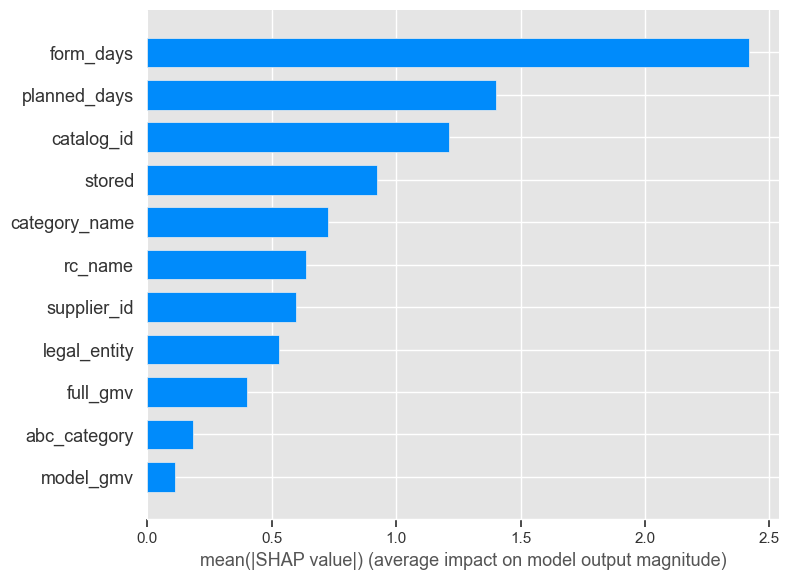

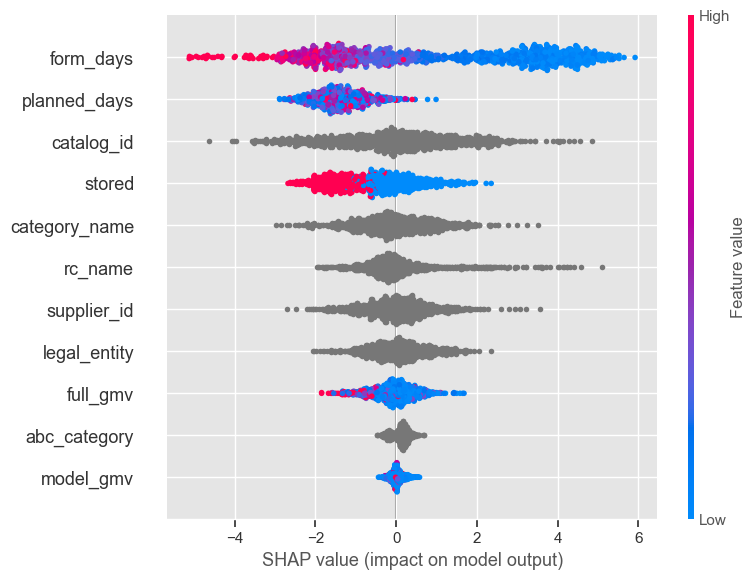

In [42]:
categorical_features = [
    'category_name', 'rc_name', 'legal_entity', 'abc_category', 'catalog_id', 'supplier_id'
]

for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# –ü–æ–ª—É—á–∞–µ–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å
best_model = automl.model.estimator
print(f"üèÜ –ò—Å–ø–æ–ª—å–∑—É–µ–º–∞—è –º–æ–¥–µ–ª—å: {type(best_model).__name__}")

# –ë–µ—Ä—ë–º –Ω–µ–±–æ–ª—å—à—É—é —á–∞—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö –¥–ª—è SHAP (—á—Ç–æ–±—ã –±—ã—Å—Ç—Ä–æ —Ä–∞–±–æ—Ç–∞–ª–æ)
X_explain = X_test.head(1000).copy()

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º Explainer –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–∏–ø–∞ –º–æ–¥–µ–ª–∏
if isinstance(best_model, (lgb.LGBMClassifier, xgb.XGBClassifier, CatBoostClassifier)):
    explainer = shap.TreeExplainer(best_model)

elif isinstance(best_model, LogisticRegression):
    explainer = shap.LinearExplainer(best_model, X_train.head(1000))

else:
    background = shap.kmeans(X_train, 500)
    explainer = shap.KernelExplainer(automl.predict_proba, background)

# –í—ã—á–∏—Å–ª—è–µ–º SHAP –∑–Ω–∞—á–µ–Ω–∏—è
shap_values = explainer.shap_values(X_explain)

# –ï—Å–ª–∏ —ç—Ç–æ –±–∏–Ω–∞—Ä–Ω–∞—è –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏—è –∏ SHAP –≤–µ—Ä–Ω—É–ª —Å–ø–∏—Å–æ–∫, –±–µ—Ä–µ–º –≤—Ç–æ—Ä–æ–π –∫–ª–∞—Å—Å
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values = shap_values[1]

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è: —Ç–æ–ø —Ñ–∏—á–µ–π (bar plot)
shap.summary_plot(shap_values, X_explain, plot_type="bar")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è: –≤–ª–∏—è–Ω–∏–µ —Ñ–∏—á–µ–π –Ω–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
shap.summary_plot(shap_values, X_explain)

# –ü—Ä–∏–º–µ—Ä –≤–ª–∏—è–Ω–∏—è —Ñ–∏—á–µ–π –Ω–∞ –∫–æ–Ω–∫—Ä–µ—Ç–Ω—ã–π –æ–±—ä–µ–∫—Ç
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_explain.iloc[0, :])

In [43]:
# –¶–µ–ª–µ–≤–∞—è –ø–µ—Ä–µ–º–µ–Ω–Ω–∞—è
target = 'form_days'

# –ü—Ä–∏–∑–Ω–∞–∫–∏
features = [
    'supplier_id', 'catalog_id', 'category_name', 'rc_name', 'legal_entity',
    'model_gmv', 'full_gmv', 'planned_days', 'stored', 'abc_category'
]

In [44]:
# –í—ã–±–∏—Ä–∞–µ–º –Ω—É–∂–Ω—ã–µ –∫–æ–ª–æ–Ω–∫–∏
X = df[features].copy()
y = df[target]

# –ë–∏–Ω–∞—Ä–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ ‚Üí int
X['stored'] = X['stored'].astype(int)

# –°–ø–∏—Å–æ–∫ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ (–ë–ï–ó stored!)
categorical_features = [
    'supplier_id', 'catalog_id', 'category_name', 
    'rc_name', 'legal_entity', 'abc_category'
]

# –ü—Ä–∏–≤–æ–¥–∏–º –∏—Ö –∫ —Ç–∏–ø—É category
X[categorical_features] = X[categorical_features].astype('category')

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
# --- 1. –°–æ–∑–¥–∞–µ–º –∏ –æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å –ë–ï–ó ExtraTreesRegressor ---
automl = AutoML()


automl.fit(
    X_train, y_train,
    task="regression",
    metric="rmse",
    time_budget=120,
    estimator_list=['lgbm', 'xgboost', 'rf']
)

# --- 2. –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è ---
y_pred = automl.predict(X_test)

[flaml.automl.logger: 06-26 23:58:58] {1752} INFO - task = regression
[flaml.automl.logger: 06-26 23:58:58] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-26 23:58:58] {1862} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 06-26 23:58:58] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'rf']
[flaml.automl.logger: 06-26 23:58:58] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-26 23:58:58] {2417} INFO - Estimated sufficient time budget=279s. Estimated necessary time budget=0s.
[flaml.automl.logger: 06-26 23:58:58] {2466} INFO -  at 0.1s,	estimator lgbm's best error=39.9037,	best estimator lgbm's best error=39.9037
[flaml.automl.logger: 06-26 23:58:58] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-26 23:58:59] {2466} INFO -  at 0.1s,	estimator lgbm's best error=39.9037,	best estimator lgbm's best error=39.9037
[flaml.automl.logger: 06-26 23:58:59] {2282} INFO - iteration 2, current lear

In [48]:
# --- 3. –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ ---
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R¬≤:", r2_score(y_test, y_pred))

# --- 4. –í—ã–≤–æ–¥ –ª—É—á—à–µ–π –º–æ–¥–µ–ª–∏ ---
print("\nüèÜ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å:", type(automl.model.estimator).__name__)

MAE: 12.461073663066003
R¬≤: 0.7440264917434698

üèÜ –õ—É—á—à–∞—è –º–æ–¥–µ–ª—å: LGBMRegressor


üèÜ –ò—Å–ø–æ–ª—å–∑—É–µ–º–∞—è –º–æ–¥–µ–ª—å: LGBMRegressor


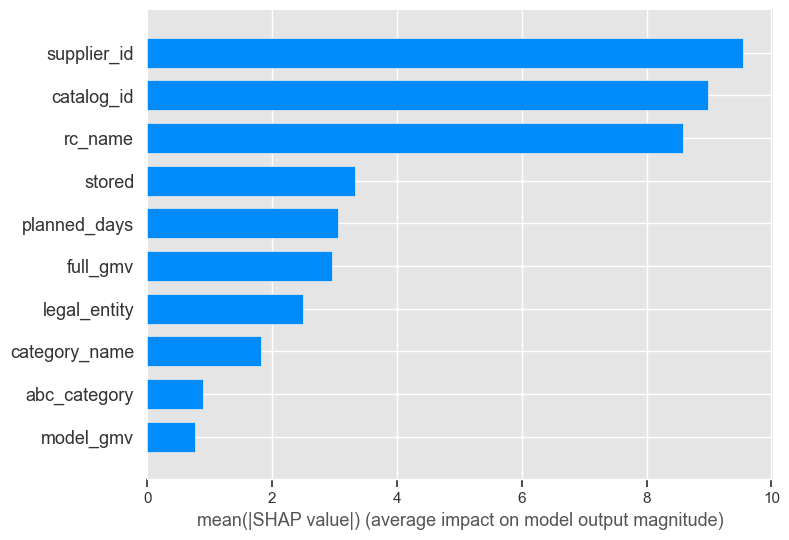

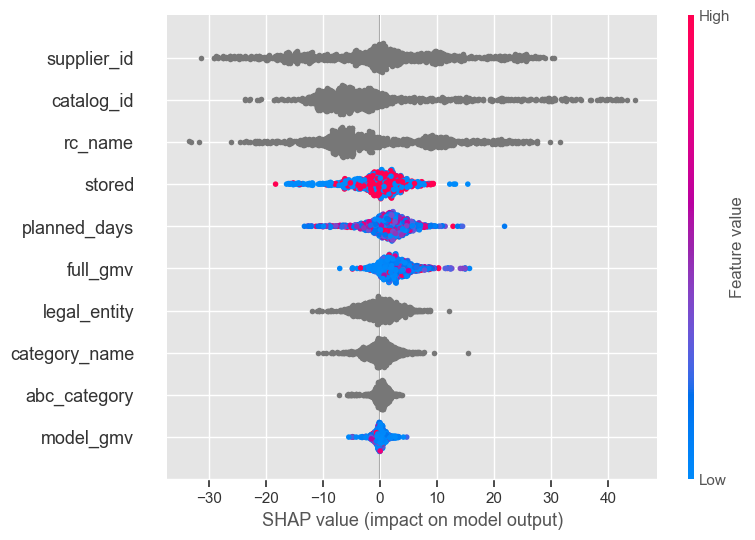

In [51]:
categorical_features = [
    'category_name', 'rc_name', 'legal_entity', 'abc_category', 'catalog_id', 'supplier_id'
]

for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')

# –ü–æ–ª—É—á–∞–µ–º –ª—É—á—à—É—é –º–æ–¥–µ–ª—å –∏–∑ AutoML
best_model = automl.model.estimator  # –∏–ª–∏ –ø—Ä–æ—Å—Ç–æ automl.model
print(f"üèÜ –ò—Å–ø–æ–ª—å–∑—É–µ–º–∞—è –º–æ–¥–µ–ª—å: {type(best_model).__name__}")

# –ë–µ—Ä—ë–º –Ω–µ–±–æ–ª—å—à—É—é —á–∞—Å—Ç—å –¥–∞–Ω–Ω—ã—Ö –¥–ª—è SHAP (—á—Ç–æ–±—ã –±—ã—Å—Ç—Ä–æ —Ä–∞–±–æ—Ç–∞–ª–æ)
X_explain = X_test.head(1000).copy()

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º Explainer –≤ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –æ—Ç —Ç–∏–ø–∞ –º–æ–¥–µ–ª–∏
if isinstance(best_model, (lgb.LGBMRegressor, xgb.XGBRegressor, CatBoostRegressor)):
    explainer = shap.TreeExplainer(best_model)

elif isinstance(best_model, LinearRegression):
    explainer = shap.LinearExplainer(best_model, X_train.head(1000))

else:
    background = shap.kmeans(X_train, 50)  # —É–º–µ–Ω—å—à–∏–ª–∏ —á–∏—Å–ª–æ –±—ç–∫–≥—Ä–∞—É–Ω–¥-—Å—ç–º–ø–ª–æ–≤ –¥–ª—è —Å–∫–æ—Ä–æ—Å—Ç–∏
    explainer = shap.KernelExplainer(automl.predict, background)

# –í—ã—á–∏—Å–ª—è–µ–º SHAP –∑–Ω–∞—á–µ–Ω–∏—è
shap_values = explainer.shap_values(X_explain)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è: —Ç–æ–ø —Ñ–∏—á–µ–π (bar plot)
shap.summary_plot(shap_values, X_explain, plot_type="bar")

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è: –≤–ª–∏—è–Ω–∏–µ —Ñ–∏—á–µ–π –Ω–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
shap.summary_plot(shap_values, X_explain)

# –ü—Ä–∏–º–µ—Ä –≤–ª–∏—è–Ω–∏—è —Ñ–∏—á–µ–π –Ω–∞ –∫–æ–Ω–∫—Ä–µ—Ç–Ω—ã–π –æ–±—ä–µ–∫—Ç
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_explain.iloc[0, :])

# –°–µ–≥–º–µ–Ω—Ç–∞—Ü–∏—è –ø–æ—Å—Ç–∞–≤—â–∏–∫–æ–≤

In [91]:
# –ì—Ä—É–ø–ø–∏—Ä—É–µ–º –ø–æ –ø–æ—Å—Ç–∞–≤—â–∏–∫—É –∏ –†–¶
supplier_by_rc = df.groupby(['supplier_id', 'rc_name']).agg(
    avg_delay_days=('delay_days', 'mean'),
    late_rate=('is_late_to_rc_delivered', 'mean'),
    avg_form_days=('form_days', 'mean'),
    total_orders=('id', 'count')
).reset_index()

# –§–∏–ª—å—Ç—Ä—É–µ–º —Ç–æ–ª—å–∫–æ —Ç–µ –≥—Ä—É–ø–ø—ã, –≥–¥–µ –µ—Å—Ç—å —Ö–æ—Ç—è –±—ã 10 –∑–∞–∫–∞–∑–æ–≤
supplier_by_rc = supplier_by_rc[supplier_by_rc['total_orders'] >= 10]
supplier_by_rc.sort_values(by='total_orders', ascending=False, inplace=True)
supplier_by_rc.head(5)

supplier_id     rc_name  avg_delay_days  late_rate  avg_form_days  \
27              8     –ö–†–° –ü–≠–ö        8.556278   0.487964      40.552375   
26              8  –ö–†–° –õ–æ–≥–õ–∞–±       23.192362   0.570721      41.301273   
38              8      –ß–ï–• –î–õ        4.995640   0.144622      23.415698   
1587         2482  –ö–†–° –õ–æ–≥–õ–∞–±        0.553980   0.249015      72.833727   
106            19         –õ–ò–ü        3.650622   0.435685     104.358506   

      total_orders  
27            1537  
26            1414  
38            1376  
1587          1269  
106           1205

In [101]:
# –ì—Ä—É–ø–ø–∏—Ä—É–µ–º –ø–æ –ø–æ—Å—Ç–∞–≤—â–∏–∫—É –∏ –†–¶
supplier_by_rc = df.groupby(['supplier_id', 'rc_name']).agg(
    avg_delay_days=('delay_days', 'mean'),
    late_rate=('is_late_to_rc_delivered', 'mean'),
    avg_form_days=('form_days', 'mean'),
    total_orders=('id', 'count')
).reset_index()

# –§–∏–ª—å—Ç—Ä—É–µ–º —Ç–æ–ª—å–∫–æ —Ç–µ –≥—Ä—É–ø–ø—ã, –≥–¥–µ –µ—Å—Ç—å —Ö–æ—Ç—è –±—ã 10 –∑–∞–∫–∞–∑–æ–≤
supplier_by_rc = supplier_by_rc[supplier_by_rc['total_orders'] >= 1]

# –°–æ–∑–¥–∞–µ–º –ø–µ—Ä–≤—É—é —Ç–∞–±–ª–∏—Ü—É –¥–ª—è late_rate
late_rate_pivot = supplier_by_rc.pivot_table(
    index='supplier_id',
    columns='rc_name',
    values='late_rate',
    aggfunc='mean'
)

# –°–æ–∑–¥–∞–µ–º –≤—Ç–æ—Ä—É—é —Ç–∞–±–ª–∏—Ü—É –¥–ª—è avg_form_days
avg_form_days_pivot = supplier_by_rc.pivot_table(
    index='supplier_id',
    columns='rc_name',
    values='avg_form_days',
    aggfunc='mean'
)

In [103]:
# –í—ã–≤–æ–¥–∏–º –ø–µ—Ä–≤—ã–µ 5 —Å—Ç—Ä–æ–∫ –∫–∞–∂–¥–æ–π —Ç–∞–±–ª–∏—Ü—ã
print("–¢–∞–±–ª–∏—Ü–∞ late_rate:")
late_rate_pivot.head()

–¢–∞–±–ª–∏—Ü–∞ late_rate:


rc_name       –ê–õ–î –Ø–¢–ê  –ê–†–¢–ï–ú –≠–π–ü–∏–¢—Ä–µ–π–¥  –ê—Ä—Ç–µ–º –õ–æ–≥–õ–∞–±  –í–û–õ–ì –ë–û–ú    –ï–ö–ë –î–õ  \
supplier_id                                                                
1            0.457143         0.862500      0.521739  0.380952  0.526316   
8            0.715867         0.945205      0.388158  0.265823  0.574713   
9            0.000000         0.250000      0.000000       NaN       NaN   
11                NaN              NaN           NaN       NaN       NaN   
12           0.800000         1.000000      0.878788  0.888889  0.000000   

rc_name       –ò—Ä–∫—É—Ç—Å–∫  –ö–ï–ú –°–ö–ê–¢  –ö–†–° –õ–æ–≥–õ–∞–±   –ö–†–° –ü–≠–ö  –ö–†–° –¢–î–õ  ...   –ú–ê–ì –ü–≠–ö  \
supplier_id                                                     ...             
1            0.312500  0.258621    0.357827  0.203922      NaN  ...  0.000000   
8            0.701493  0.574850    0.570721  0.487964      NaN  ...  1.000000   
9            1.000000  0.000000    0.250000  0.666667      NaN  ...       NaN   
11                NaN  1.000000    0.512821       NaN      NaN  ...       NaN   
12           0.846154  0.312500    0.194030       NaN      NaN  ...  0.714286   

rc_name      –ú–£–†–ú–ê–ù–°–ö –ú–ó–ß  –ù–ï–í–°–°–ö –°–¢–ê–†  –ü–ï–†–ú–¨ –ü–≠–ö  –†–¶ –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫ –î–õ  \
supplier_id                                                            
1                0.372881     0.417910   0.464286                1.0   
8                0.223561     0.613065   0.169231                1.0   
9                0.000000     0.000000        NaN                NaN   
11               0.962963          NaN   0.444444                NaN   
12               0.000000     0.711538   0.166667                NaN   

rc_name      –†–¶ –•–∞–±–∞—Ä–æ–≤—Å–∫     –°–ü–ë-1  –¢—é–º–µ–Ω—å –ì–†–ó–ù  –ß–ï–õ    –ß–ï–• –î–õ  
supplier_id                                                      
1                0.650000  0.500000          NaN  0.0  0.441441  
8                0.826087  0.185841          1.0  1.0  0.144622  
9                     NaN  0.000000          NaN  NaN       NaN  
11                    NaN  0.357143          NaN  NaN  0.250000  
12               0.555556  0.200000          NaN  0.0  0.326087  

[5 rows x 21 columns]

In [105]:
print("\n–¢–∞–±–ª–∏—Ü–∞ avg_form_days:")
avg_form_days_pivot.head()


–¢–∞–±–ª–∏—Ü–∞ avg_form_days:


rc_name        –ê–õ–î –Ø–¢–ê  –ê–†–¢–ï–ú –≠–π–ü–∏–¢—Ä–µ–π–¥  –ê—Ä—Ç–µ–º –õ–æ–≥–õ–∞–±   –í–û–õ–ì –ë–û–ú     –ï–ö–ë –î–õ  \
supplier_id                                                                   
1            68.100000        29.300000    155.000000   7.571429  14.368421   
8            55.911439        91.424658     36.578947  12.139241  14.896552   
9             0.000000         8.000000     11.333333        NaN        NaN   
11                 NaN              NaN           NaN        NaN        NaN   
12            0.000000        60.923077     67.666667   0.000000   0.000000   

rc_name        –ò—Ä–∫—É—Ç—Å–∫   –ö–ï–ú –°–ö–ê–¢  –ö–†–° –õ–æ–≥–õ–∞–±    –ö–†–° –ü–≠–ö  –ö–†–° –¢–î–õ  ...  \
supplier_id                                                        ...   
1            32.093750  52.612069  114.281150  61.458824      NaN  ...   
8            26.880597  24.972056   41.301273  40.552375      NaN  ...   
9             0.000000   2.400000    4.687500   2.333333      NaN  ...   
11                 NaN  17.866667   74.769231        NaN      NaN  ...   
12            0.000000  16.593750  147.955224        NaN      NaN  ...   

rc_name      –ú–ê–ì –ü–≠–ö  –ú–£–†–ú–ê–ù–°–ö –ú–ó–ß  –ù–ï–í–°–°–ö –°–¢–ê–†  –ü–ï–†–ú–¨ –ü–≠–ö  –†–¶ –ù–æ–≤–æ—Å–∏–±–∏—Ä—Å–∫ –î–õ  \
supplier_id                                                                     
1                2.0     77.677966    36.223881  22.571429                0.0   
8                0.0     18.552878    18.869347  15.994872                0.0   
9                NaN      0.000000     3.000000        NaN                NaN   
11               NaN     64.000000          NaN  57.000000                NaN   
12               0.0      0.000000    57.942308  29.000000                NaN   

rc_name      –†–¶ –•–∞–±–∞—Ä–æ–≤—Å–∫      –°–ü–ë-1  –¢—é–º–µ–Ω—å –ì–†–ó–ù  –ß–ï–õ     –ß–ï–• –î–õ  
supplier_id                                                        
1               17.250000  29.125000          NaN  0.0  32.621622  
8                1.217391  28.924147          0.0  8.0  23.415698  
9                     NaN   0.000000          NaN  NaN        NaN  
11                    NaN  29.000000          NaN  NaN  48.000000  
12               8.944444   0.000000          NaN  0.0  11.913043  

[5 rows x 21 columns]

In [53]:
# –°–æ—Ä—Ç–∏—Ä–æ–≤–∫–∞ –ø–æ late_rate –∏ delay_days –¥–ª—è –ø–æ–∏—Å–∫–∞ "–ª—É—á—à–∏—Ö" –∏ "—Ö—É–¥—à–∏—Ö"
top_performers = supplier_by_rc.sort_values(by=['late_rate', 'avg_delay_days'], ascending=[True, True]).head(10)
worst_performers = supplier_by_rc.sort_values(by=['late_rate', 'avg_delay_days'], ascending=[False, False]).head(10)

# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
print("üèÜ –õ—É—á—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –†–¶:")
top_performers

üèÜ –õ—É—á—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –†–¶:


supplier_id       rc_name  avg_delay_days  late_rate  avg_form_days  \
636           498   –ù–ï–í–°–°–ö –°–¢–ê–†      -50.300000        0.0      59.200000   
1156         1415  –ú–£–†–ú–ê–ù–°–ö –ú–ó–ß      -47.294118        0.0      30.000000   
1161         1415        –ß–ï–• –î–õ      -41.920000        0.0      15.400000   
1153         1415    –ö–†–° –õ–æ–≥–õ–∞–±      -40.537037        0.0      30.851852   
429           285      –ö–ï–ú –°–ö–ê–¢      -35.545455        0.0       3.272727   
1152         1415      –ö–ï–ú –°–ö–ê–¢      -34.861111        0.0      32.777778   
431           285           –õ–ò–ü      -34.767442        0.0       6.837209   
632           498    –ö–†–° –õ–æ–≥–õ–∞–±      -34.523810        0.0      79.809524   
339           216  –ú–£–†–ú–ê–ù–°–ö –ú–ó–ß      -32.066667        0.0      47.800000   
1157         1415   –ù–ï–í–°–°–ö –°–¢–ê–†      -30.612903        0.0      13.225806   

      total_orders  
636             10  
1156            17  
1161            25  
1153            54  
429             11  
1152            36  
431             86  
632             42  
339             15  
1157            31

In [54]:
print("\n‚ö†Ô∏è –•—É–¥—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –†–¶:")
worst_performers


‚ö†Ô∏è –•—É–¥—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –†–¶:


supplier_id          rc_name  avg_delay_days  late_rate  avg_form_days  \
29             8          –ú–ê–ì –ü–≠–ö      240.142857        1.0       0.000000   
835          855       –ö–†–° –õ–æ–≥–õ–∞–±       99.583333        1.0      25.500000   
833          855     –ê—Ä—Ç–µ–º –õ–æ–≥–õ–∞–±       88.266667        1.0     145.483333   
831          855          –ê–õ–î –Ø–¢–ê       82.684211        1.0      31.473684   
470          304         –ö–ï–ú –°–ö–ê–¢       80.523810        1.0      36.190476   
366          227              –õ–ò–ü       79.000000        1.0      28.000000   
56            12  –ê–†–¢–ï–ú –≠–π–ü–∏–¢—Ä–µ–π–¥       76.653846        1.0      60.923077   
472          304              –õ–ò–ü       64.846154        1.0       7.384615   
308          200              –õ–ò–ü       63.454545        1.0       8.727273   
867          914          –ò—Ä–∫—É—Ç—Å–∫       58.733333        1.0      53.400000   

     total_orders  
29             28  
835            12  
833            60  
831            19  
470            21  
366            10  
56             26  
472            13  
308            11  
867            15

In [55]:
# –ì—Ä—É–ø–ø–∏—Ä—É–µ–º –ø–æ –ø–æ—Å—Ç–∞–≤—â–∏–∫—É –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∏
supplier_by_category = df.groupby(['supplier_id', 'category_name']).agg(
    avg_delay_days=('delay_days', 'mean'),
    late_rate=('is_late_to_rc_delivered', 'mean'),
    avg_form_days=('form_days', 'mean'),
    total_orders=('id', 'count')
).reset_index()

# –§–∏–ª—å—Ç—Ä—É–µ–º –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –∑–∞–∫–∞–∑–æ–≤
supplier_by_category = supplier_by_category[supplier_by_category['total_orders'] >= 10]
supplier_by_category.sort_values(by='total_orders', ascending=False, inplace=True)
supplier_by_category.head(5)

supplier_id category_name  avg_delay_days  late_rate  avg_form_days  \
3944          857         –ë–æ–ª—Ç—ã        2.814904   0.510817      72.330529   
463             8         –ü–∞–ø–∫–∞       13.432266   0.418719      30.141626   
484             8         –†—É—á–∫–∞       11.886398   0.399103      30.037369   
432             8        –ú–∞—Ä–∫–µ—Ä       10.751689   0.444257      32.033784   
1467          128         –ë–æ–ª—Ç—ã        6.166311   0.398721      13.588486   

      total_orders  
3944           832  
463            812  
484            669  
432            592  
1467           469

In [56]:
# –õ—É—á—à–∏–µ –ø–∞—Ä—ã: –º–∏–Ω–∏–º–∞–ª—å–Ω–∞—è –¥–æ–ª—è –ø—Ä–æ—Å—Ä–æ—á–µ–∫ –∏ –∑–∞–¥–µ—Ä–∂–∫–∞
top_performers_cat = supplier_by_category.sort_values(
    by=['late_rate', 'avg_delay_days'], 
    ascending=[True, True]
).head(10)

# –•—É–¥—à–∏–µ –ø–∞—Ä—ã: –º–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è –¥–æ–ª—è –ø—Ä–æ—Å—Ä–æ—á–µ–∫ –∏ –∑–∞–¥–µ—Ä–∂–∫–∞
worst_performers_cat = supplier_by_category.sort_values(
    by=['late_rate', 'avg_delay_days'], 
    ascending=[False, False]
).head(10)

# –í—ã–≤–æ–¥
print("üèÜ –õ—É—á—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –∫–∞—Ç–µ–≥–æ—Ä–∏—è:")
top_performers_cat

üèÜ –õ—É—á—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –∫–∞—Ç–µ–≥–æ—Ä–∏—è:


supplier_id                        category_name  avg_delay_days  \
5078         1415                          –§—Ç–æ—Ä–æ–ø–ª–∞—Å—Ç—ã      -51.473684   
5060         1415  –ö–ª–∏–Ω–æ–≤—ã–µ —Ä–µ–º–Ω–∏ –¥–ª—è —Ç–æ–∫–∞—Ä–Ω—ã—Ö —Å—Ç–∞–Ω–∫–æ–≤      -50.409091   
6561         2456                    –ö–Ω–æ–ø–∫–∏ —É–ø—Ä–∞–≤–ª–µ–Ω–∏—è      -48.827586   
869            18                –®–∫–∞—Ñ –¥–ª—è –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–≤      -43.166667   
5069         1415                  –°–∞–ª—å–Ω–∏–∫–æ–≤—ã–µ –Ω–∞–±–∏–≤–∫–∏      -37.529412   
5075         1415                 –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ –ø–ª–∞—Å—Ç–∏–Ω—ã      -36.720000   
3143          524                                –í–µ–¥—Ä–æ      -33.500000   
3903          855            –ù–∞–±–æ—Ä —à–µ—Å—Ç–∏–≥—Ä–∞–Ω–Ω—ã—Ö –∫–ª—é—á–µ–π      -33.142857   
5068         1415                      –†—É–∫–∞–≤–∞ –Ω–∞–ø–æ—Ä–Ω—ã–µ      -32.770833   
3886          855                     –ó—É–±–∏–ª–æ –∫—É–∑–Ω–µ—á–Ω–æ–µ      -30.545455   

      late_rate  avg_form_days  total_orders  
5078        0.0      19.947368            19  
5060        0.0      30.363636            22  
6561        0.0      65.862069            29  
869         0.0      39.416667            12  
5069        0.0      15.705882            17  
5075        0.0      21.920000            25  
3143        0.0      49.300000            10  
3903        0.0      84.000000            14  
5068        0.0      20.833333            48  
3886        0.0      83.090909            11

In [57]:
print("\n‚ö†Ô∏è –•—É–¥—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –∫–∞—Ç–µ–≥–æ—Ä–∏—è:")
worst_performers_cat


‚ö†Ô∏è –•—É–¥—à–∏–µ –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏ –ø–æ—Å—Ç–∞–≤—â–∏–∫ + –∫–∞—Ç–µ–≥–æ—Ä–∏—è:


supplier_id              category_name  avg_delay_days  late_rate  \
3906          855          –ù–∞–ø–∞–π–Ω—ã–µ –ø–ª–∞—Å—Ç–∏–Ω—ã      106.818182   1.000000   
3911          855          –ü–ª–∞—Å—Ç–∏–Ω—ã —Ç–æ–∫–∞—Ä–Ω—ã–µ       77.416667   1.000000   
1229           82       –ö–æ–º–±–∏–Ω–∏—Ä–æ–≤–∞–Ω–Ω—ã–π –∫–ª—é—á       46.032258   1.000000   
1223           82           –ó—É–±–∏–ª–æ —Å–ª–µ—Å–∞—Ä–Ω–æ–µ       34.700000   1.000000   
5501         1610                  –†–∞–∑–≤–µ—Ä—Ç–∫–∏       31.411765   1.000000   
2480          305                    –¢–µ—Ç—Ä–∞–¥–∏       20.083333   1.000000   
6152         2088                  –†–∞–∑–≤–µ—Ä—Ç–∫–∏       14.333333   1.000000   
1277           82              –†–æ–∂–∫–æ–≤—ã–π –∫–ª—é—á       39.513514   0.972973   
4438          914        –ú—É—Ñ—Ç—ã –∏ –ø–µ—Ä–µ—Ö–æ–¥–Ω–∏–∫–∏       60.150000   0.950000   
4453          914  –°–æ–µ–¥–∏–Ω–∏—Ç–µ–ª–∏ –∏ –ø–µ—Ä–µ—Ö–æ–¥–Ω–∏–∫–∏       46.950000   0.950000   

      avg_form_days  total_orders  
3906      34.000000            11  
3911     115.916667            12  
1229      47.129032            31  
1223      52.000000            10  
5501       0.000000            17  
2480      52.083333            12  
6152      23.333333            12  
1277      56.216216            37  
4438      22.350000            20  
4453      22.800000            20

### **–ö–ª—é—á–µ–≤—ã–µ –≤—ã–≤–æ–¥—ã:**
1. **–û—Å–Ω–æ–≤–Ω–∞—è –ø—Ä–æ–±–ª–µ–º–∞ –≤—ã—è–≤–ª–µ–Ω–∞:**  
   –ö–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è –∑–∞–∫–∞–∑–æ–≤ —Å–∞–º–∞ –ø–æ —Å–µ–±–µ –Ω–µ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç –æ–±—â–∏–µ –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–æ—Å—Ç–∞–≤–∫–∏. –û–¥–Ω–∞–∫–æ "—Å—Ç–∞—Ä—ã–µ" –∑–∞–∫–∞–∑—ã (—Ç–µ, —á—Ç–æ –¥–æ–ª–≥–æ –∂–¥—É—Ç –æ—Ç–ø—Ä–∞–≤–∫–∏ –≤ –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä–æ–≤–∞–Ω–Ω–æ–π –ø–∞—Ä—Ç–∏–∏) –¥–µ–π—Å—Ç–≤–∏—Ç–µ–ª—å–Ω–æ –ø–æ–ª—É—á–∞—é—Ç –±–æ–ª—å—à–µ –∑–∞–¥–µ—Ä–∂–µ–∫.

2. **–ö—Ä–∏—Ç–∏—á–µ—Å–∫–∏–π –ø–æ—Ä–æ–≥ –≤—Ä–µ–º–µ–Ω–∏ —Å–±–æ—Ä–∫–∏ –≥—Ä—É–∑–æ–≤:**  
   –ï—Å–ª–∏ –≤—Ä–µ–º—è —Å–±–æ—Ä–∫–∏ –≥—Ä—É–∑–æ–≤ –ø—Ä–µ–≤—ã—à–∞–µ—Ç **6 –¥–Ω–µ–π**, —Ä–µ–∑–∫–æ –≤–æ–∑—Ä–∞—Å—Ç–∞–µ—Ç —Ä–∏—Å–∫ –∑–∞–¥–µ—Ä–∂–µ–∫ –¥–ª—è "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤.

3. **–§–æ–∫—É—Å –Ω–∞ "—Å—Ç–∞—Ä—ã–µ" –∑–∞–∫–∞–∑—ã:**  
   –ü—Ä–æ–±–ª–µ–º–∞ –∫–∞—Å–∞–µ—Ç—Å—è –∏–º–µ–Ω–Ω–æ —Ç–µ—Ö –∑–∞–∫–∞–∑–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –¥–æ–ª–≥–æ –Ω–∞—Ö–æ–¥—è—Ç—Å—è –≤ –æ—á–µ—Ä–µ–¥–∏ –Ω–∞ –æ—Ç–ø—Ä–∞–≤–∫—É, –∞ –Ω–µ –≤—Å–µ—Ö –∑–∞–∫–∞–∑–æ–≤ –≤ —Ü–µ–ª–æ–º.

4. **–í–ª–∏—è–Ω–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞ –Ω–∞ –ø—Ä–æ–≥–Ω–æ–∑ –≤—Ä–µ–º–µ–Ω–∏ —Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏—è (–∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ –ø–æ–¥–∑–∞–∫–∞–∑–æ–≤):**  
   –ù–∞–∏–±–æ–ª—å—à–µ–µ –≤–ª–∏—è–Ω–∏–µ:

   - –ü–æ—Å—Ç–∞–≤—â–∏–∫
   - –†–¶

   –ù–µ–∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ–µ –≤–ª–∏—è–Ω–∏–µ:

   - –ö–∞—Ç–µ–≥–æ—Ä–∏—è
   - –û–±–æ—Ä–æ—Ç –ø–æ—Å—Ç–∞–≤—â–∏–∫–∞   

---

### **–†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –¥–ª—è –±–∏–∑–Ω–µ—Å–∞:**
1. **–û–≥—Ä–∞–Ω–∏—á–∏—Ç—å –≤—Ä–µ–º—è —Å–±–æ—Ä–∫–∏ –≥—Ä—É–∑–æ–≤ –¥–æ 5 –¥–Ω–µ–π.**  
   –≠—Ç–æ –ø–æ–∑–≤–æ–ª–∏—Ç –º–∏–Ω–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å –∑–∞–¥–µ—Ä–∂–∫–∏ –¥–ª—è "—Å—Ç–∞—Ä—ã—Ö" –∑–∞–∫–∞–∑–æ–≤ –∏ —É–ª—É—á—à–∏—Ç—å –æ–±—â–∏–π —É—Ä–æ–≤–µ–Ω—å —Å–µ—Ä–≤–∏—Å–∞.

In [109]:
from pandas import ExcelWriter

# –£–∫–∞–∂–∏—Ç–µ –ø—É—Ç—å –∏ –∏–º—è —Ñ–∞–π–ª–∞ –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è
output_file = "supplier_analysis_report.xlsx"

# –°–æ–∑–¥–∞–µ–º ExcelWriter
with ExcelWriter(output_file, engine='openpyxl') as writer:
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ç–∞–±–ª–∏—Ü—É late_rate –Ω–∞ –ø–µ—Ä–≤—ã–π –ª–∏—Å—Ç
    late_rate_pivot.to_excel(writer, sheet_name='Late Rate')
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ç–∞–±–ª–∏—Ü—É avg_form_days –Ω–∞ –≤—Ç–æ—Ä–æ–π –ª–∏—Å—Ç
    avg_form_days_pivot.to_excel(writer, sheet_name='Avg Form Days')
    
    # –°–æ—Ö—Ä–∞–Ω—è–µ–º final_report –Ω–∞ —Ç—Ä–µ—Ç–∏–π –ª–∏—Å—Ç
    final_report.to_excel(writer, sheet_name='Final Report')

print(f"–û—Ç—á–µ—Ç —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ —Ñ–∞–π–ª: {output_file}")

–û—Ç—á–µ—Ç —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ —Ñ–∞–π–ª: supplier_analysis_report.xlsx
